In [1]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime as dt
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
import yaml
import requests
from pathlib import Path
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [2]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [5]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Coinbase Utility Functions

In [8]:
def get_coinbase_historical_price_data(
    client,
    ticker,
    start_timestamp,
    end_timestamp,
    granularity="ONE_DAY",
    retries=3,
    delay=5,
):
    """
    Generic candle puller for Coinbase Advanced Trade RESTClient.get_candles().

    granularity examples:
      ONE_MINUTE, FIVE_MINUTE, FIFTEEN_MINUTE, THIRTY_MINUTE,
      ONE_HOUR, TWO_HOUR, FOUR_HOUR, SIX_HOUR, ONE_DAY
    """
    attempts = 0
    while attempts < retries:
        try:
            candle_list = client.get_candles(
                product_id=ticker,
                start=int(start_timestamp),
                end=int(end_timestamp),
                granularity=granularity,
            ).candles

            if not candle_list:
                cols = ["open", "high", "low", "close", "volume"]
                return pd.DataFrame(columns=cols).rename_axis("date")

            candle_data = []
            for c in candle_list:
                candle_data.append(
                    {
                        "date": c["start"],  # epoch seconds
                        "low": float(c["low"]),
                        "high": float(c["high"]),
                        "open": float(c["open"]),
                        "close": float(c["close"]),
                        "volume": float(c["volume"]),
                    }
                )

            df = pd.DataFrame(candle_data)
            if df.empty or "date" not in df.columns:
                cols = ["open", "high", "low", "close", "volume"]
                return pd.DataFrame(columns=cols).rename_axis("date")

            # epoch seconds -> tz-aware UTC -> drop tz (tz-naive UTC)
            s = pd.to_datetime(pd.to_numeric(df["date"], errors="coerce"), unit="s", utc=True).dt.tz_localize(None)

            # Only normalize for daily bars; keep intraday timestamps intact
            if granularity == "ONE_DAY":
                s = s.dt.normalize()

            df["date"] = s
            df = df.set_index("date").sort_index().rename_axis("date")

            return df

        except requests.exceptions.ConnectionError as e:
            print(f"Connection error: {e}. Retrying in {delay} seconds...")
            attempts += 1
            time.sleep(delay)

    raise Exception("Max retries exceeded. Could not connect to Coinbase API.")


In [10]:
def save_historical_crypto_prices_from_coinbase(
    ticker,
    user_start_date=False,
    start_date=None,
    end_date=None,
    save_to_file=False,
    portfolio_name="Default",
    granularity="ONE_DAY",
):
    """
    Pull historical candles for a single ticker at the requested granularity.

    Note: Coinbase candle endpoints have request caps (commonly 300 candles per call),
    so we chunk requests.
    """
    client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)

    if user_start_date:
        start_date = pd.Timestamp(start_date)
    else:
        start_date = cn.coinbase_start_date_by_ticker_dict.get(ticker)
        start_date = pd.Timestamp(start_date)
        if start_date is None:
            print(f"Start date for {ticker} is not included in the dictionary!")
            return None

    end_date = pd.Timestamp(end_date)

    # seconds per bar (used to step chunks without gaps)
    granularity_to_seconds = {
        "ONE_MINUTE": 60,
        "FIVE_MINUTE": 300,
        "FIFTEEN_MINUTE": 900,
        "THIRTY_MINUTE": 1800,
        "ONE_HOUR": 3600,
        "TWO_HOUR": 7200,
        "FOUR_HOUR": 14400,
        "SIX_HOUR": 21600,
        "ONE_DAY": 86400,
    }
    bar_sec = granularity_to_seconds.get(granularity)
    if bar_sec is None:
        raise ValueError(f"Unsupported granularity: {granularity}")

    # Keep your old 6-week chunking (works great for ONE_DAY and FOUR_HOUR),
    # but ensure we never step by +1 day when doing intraday.
    temp_start = start_date
    current_end = temp_start

    dfs = []
    while current_end < end_date:
        # 6 weeks is safe for FOUR_HOUR (≈252 candles) under the typical 300 limit :contentReference[oaicite:1]{index=1}
        current_end = pd.to_datetime(temp_start) + dt.timedelta(weeks=6)
        if current_end > end_date:
            current_end = end_date

        start_ts = int(pd.Timestamp(temp_start).timestamp())
        end_ts = int(pd.Timestamp(current_end).timestamp())

        df_chunk = get_coinbase_historical_price_data(
            client=client,
            ticker=ticker,
            start_timestamp=start_ts,
            end_timestamp=end_ts,
            granularity=granularity,
        )
        dfs.append(df_chunk)

        # advance by exactly one bar to avoid duplicates and avoid gaps
        temp_start = pd.to_datetime(current_end) + pd.Timedelta(seconds=bar_sec)

    if not dfs:
        cols = ["open", "high", "low", "close", "volume"]
        return pd.DataFrame(columns=cols).rename_axis("date")

    df = pd.concat(dfs, axis=0)
    df = df[~df.index.duplicated(keep="last")].sort_index()

    # optional: save_to_file logic can stay as you had it (not shown in your snippet)

    return df


In [12]:
cn_ticker_list = cn.coinbase_start_date_by_ticker_dict

In [14]:
cn_ticker_list

{'BTC-USD': '2016-01-01',
 'ETH-USD': '2016-06-01',
 'SOL-USD': '2021-06-01',
 'ADA-USD': '2021-03-01',
 'AVAX-USD': '2021-09-01',
 'DOT-USD': '2021-06-01',
 'ATOM-USD': '2020-01-01',
 'LTC-USD': '2016-09-01',
 'XRP-USD': '2023-06-01',
 'ALGO-USD': '2019-08-01',
 'XLM-USD': '2019-02-01',
 'TON-USD': '2025-11-18',
 'NEAR-USD': '2022-09-01',
 'ICP-USD': '2021-05-10',
 'HBAR-USD': '2022-10-13',
 'SUI-USD': '2023-05-18',
 'CRO-USD': '2021-11-01',
 'APT-USD': '2022-10-19',
 'XTZ-USD': '2019-08-06',
 'EGLD-USD': '2022-12-07',
 'FIL-USD': '2020-12-09',
 'SEI-USD': '2023-08-15',
 'TIA-USD': '2023-11-01',
 'KAVA-USD': '2023-01-19',
 'ROSE-USD': '2022-04-26',
 'MATIC-USD': '2021-02-01',
 'SKL-USD': '2021-02-01',
 'OP-USD': '2022-06-01',
 'ARB-USD': '2023-03-23',
 'POL-USD': '2024-09-04',
 'IMX-USD': '2021-12-09',
 'STRK-USD': '2024-02-21',
 'BLAST-USD': '2024-06-26',
 'ZK-USD': '2024-09-25',
 'LRC-USD': '2020-09-15',
 'ZORA-USD': '2025-04-24',
 'METIS-USD': '2022-06-28',
 'STX-USD': '2022-01-20'

In [16]:
ticker_list = []
exclude_list = ['USDT-USD','DAI-USD','USD1-USD','PAX-USD','MATIC-USD']
for ticker, date in cn_ticker_list.items():
    if (pd.Timestamp(cn_ticker_list[ticker]).date() <= pd.Timestamp('2022-04-01').date()) & (ticker not in exclude_list):
        ticker_list.append(ticker)

In [18]:
print(len(ticker_list))
ticker_list

40


['BTC-USD',
 'ETH-USD',
 'SOL-USD',
 'ADA-USD',
 'AVAX-USD',
 'DOT-USD',
 'ATOM-USD',
 'LTC-USD',
 'ALGO-USD',
 'XLM-USD',
 'ICP-USD',
 'CRO-USD',
 'XTZ-USD',
 'FIL-USD',
 'SKL-USD',
 'IMX-USD',
 'LRC-USD',
 'STX-USD',
 'DOGE-USD',
 'SHIB-USD',
 'LINK-USD',
 'FET-USD',
 'GRT-USD',
 'RNDR-USD',
 'OXT-USD',
 'AIOZ-USD',
 'DIA-USD',
 'KRL-USD',
 'UNI-USD',
 'AAVE-USD',
 'AMP-USD',
 'COMP-USD',
 'MKR-USD',
 'SNX-USD',
 'SUSHI-USD',
 'CRV-USD',
 'BAL-USD',
 '1INCH-USD',
 'MANA-USD',
 'REQ-USD']

In [20]:
def get_coinbase_price_data_for_ticker_list(start_date, end_date, ticker_list):

    df_dict_by_ticker = {}
    ticker_list_len = len(ticker_list)
    loop_start = 0
    loop_end = 0
    counter = 0
    while counter < ticker_list_len:
        loop_start = counter
        if counter == 40:
            loop_end = ticker_list_len
        else:
            loop_end = counter + 10
        print(counter, loop_start, loop_end, ticker_list[loop_start: loop_end])
        for t in ticker_list[loop_start: loop_end]:
            df_dict_by_ticker[t] = save_historical_crypto_prices_from_coinbase(
                ticker=t,
                user_start_date=True,
                start_date=start_date,
                end_date=end_date,
                portfolio_name="Default",
                granularity="FOUR_HOUR",
            )
        counter += 10
    
    # Optional: one combined frame (MultiIndex: ticker, date)
    df_all = pd.concat(df_dict_by_ticker, names=["ticker", "date"]).sort_index()
    df_all = df_all.reset_index()

    return df_all

In [28]:
%%time
start_date = "2022-04-01"
end_date   = "2024-12-31"
# df_ticker_price = get_coinbase_price_data_for_ticker_list(start_date, end_date, ticker_list)

CPU times: user 9 μs, sys: 3 μs, total: 12 μs
Wall time: 20 μs


In [ ]:
df_ticker_price.shape

In [ ]:
## Save Files to Parquet for later use
df_ticker_price.to_parquet(
    f"/Users/adheerchauhan/Documents/git/trend_following/data_folder/coinbase_4_min_bar_data/coinbase_ohlcv_4min_{start_date}-{end_date}.parquet",
    index=False,
    compression="zstd",  # great balance of size + speed
)

In [30]:
## Read Parquet Files
df_ticker_price = pd.read_parquet(f"/Users/adheerchauhan/Documents/git/trend_following/data_folder/coinbase_4_min_bar_data/coinbase_ohlcv_4min_{start_date}-{end_date}.parquet")

In [32]:
df_ticker_price.head()

,ticker,date,low,high,open,close,volume
0,1INCH-USD,2022-04-01 00:00:00,1.670,1.792,1.777,1.708,193718.75
1,1INCH-USD,2022-04-01 04:00:00,1.707,1.756,1.709,1.755,64858.85
2,1INCH-USD,2022-04-01 08:00:00,1.738,1.772,1.757,1.747,43729.16
3,1INCH-USD,2022-04-01 12:00:00,1.710,1.831,1.744,1.816,149897.91
4,1INCH-USD,2022-04-01 16:00:00,1.809,1.885,1.819,1.880,167483.50


In [34]:
df_ticker_price.shape

(241229, 7)

In [36]:
df_ticker_price.groupby(['ticker']).size()

ticker
1INCH-USD    6031
AAVE-USD     6031
ADA-USD      6031
AIOZ-USD     6031
ALGO-USD     6031
AMP-USD      6031
ATOM-USD     6031
AVAX-USD     6031
BAL-USD      6031
BTC-USD      6031
COMP-USD     6031
CRO-USD      6031
CRV-USD      6031
DIA-USD      6031
DOGE-USD     6031
DOT-USD      6031
ETH-USD      6031
FET-USD      6031
FIL-USD      6031
GRT-USD      6031
ICP-USD      6031
IMX-USD      6031
KRL-USD      6020
LINK-USD     6031
LRC-USD      6031
LTC-USD      6031
MANA-USD     6031
MKR-USD      6031
OXT-USD      6031
REQ-USD      6031
RNDR-USD     6031
SHIB-USD     6031
SKL-USD      6031
SNX-USD      6031
SOL-USD      6031
STX-USD      6031
SUSHI-USD    6031
UNI-USD      6031
XLM-USD      6031
XTZ-USD      6031
dtype: int64

## Build Return Features

In [39]:
def calculate_z_score(df, return_col, date_col, z_score_col_name):

    return_mean = df.groupby([date_col])[return_col].transform('mean')
    return_std = df.groupby([date_col])[return_col].transform('std').replace(0, np.nan)
    df[z_score_col_name] = (df[return_col] - return_mean) / return_std

    return df
    

def build_return_features(df, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50):

    df_returns = df.copy()

    ## Get Previour 4 hour returns
    ticker_group_close = df_returns.groupby(['ticker'])['close']
    df_returns['close_log_return_prev_4h'] = np.log(ticker_group_close.shift(1) / ticker_group_close.shift(2))

    ## Require a minimum number of tickers to calculate Z-Score for a given bar
    ticker_count_by_date = df_returns.groupby(['date'])['ticker'].transform('nunique')
    df_returns = df_returns[ticker_count_by_date >= min_z_score_ticker_count]

    ## Calculate cross-sectional Z-Score across all tickers per bar
    df_returns = calculate_z_score(df_returns, return_col='close_log_return_prev_4h', date_col='date', z_score_col_name='close_log_return_z_score_prev_4h')

    ## Get forward return for specified period (Open(T) to Open(T+H))
    df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'] = np.log(df_returns.groupby(['ticker'])['open'].shift(-fwd_return_period) / df_returns['open'])

    ## Winsorize Forward Return to reduce data glitches
    if winsorize_fwd_return:
        df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'] = df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'].clip(-fwd_return_cap, fwd_return_cap)

    return df_returns

In [41]:
df_returns = build_return_features(df_ticker_price, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50)

In [43]:
df_returns.shape

(241229, 10)

In [45]:
df_returns.head()

,ticker,date,low,high,open,close,volume,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h
0,1INCH-USD,2022-04-01 00:00:00,1.670,1.792,1.777,1.708,193718.75,NaN,NaN,-0.018745
1,1INCH-USD,2022-04-01 04:00:00,1.707,1.756,1.709,1.755,64858.85,NaN,NaN,0.062378
2,1INCH-USD,2022-04-01 08:00:00,1.738,1.772,1.757,1.747,43729.16,0.027146,0.152888,0.068196
3,1INCH-USD,2022-04-01 12:00:00,1.710,1.831,1.744,1.816,149897.91,-0.004569,0.127891,0.074558
4,1INCH-USD,2022-04-01 16:00:00,1.809,1.885,1.819,1.880,167483.50,0.038736,-0.044778,0.058196


In [47]:
return_cols = ['close_log_return_prev_4h','fwd_open_log_return_12h']
df_signal = df_returns.dropna(subset=return_cols).copy()

In [49]:
## Analyze the Decile Performance by date for this signal
def cs_bucket(group, col, q=10):
    # cross-sectional bucketing within each timestamp
    return pd.qcut(group[col], q=q, labels=False, duplicates="drop")

df_signal["quantile_bucket"] = df_signal.groupby("date", group_keys=False).apply(
    lambda g: cs_bucket(g, "close_log_return_z_score_prev_4h", q=10)
)

bucket_stats = (
    df_signal.dropna(subset=["quantile_bucket"])
    .groupby("quantile_bucket")["fwd_open_log_return_12h"]
    .agg(["mean", "std", "count"])
)
bucket_stats["t_stat"] = bucket_stats["mean"] / (bucket_stats["std"] / np.sqrt(bucket_stats["count"]))
## Denominator here is the Standard Error calculated as STD / sqrt(N). The t-stat calculates how many
## standard errors the observed mean is away from 0
## T-Stat assumes IID (which may not be the case) and n is large enough where the distribution is normal using Central Limit Theorem
bucket_stats


,mean,std,count,t_stat
quantile_bucket,,,,
0,0.000573,0.041399,24163,2.151805
1,0.000351,0.034978,24146,1.558317
2,0.000169,0.033933,24167,0.776218
3,0.000112,0.033033,24075,0.527198
4,-0.000078,0.033050,24109,-0.365559
5,-0.000138,0.032704,24093,-0.655222
6,-0.000233,0.033269,24089,-1.088319
7,-0.000460,0.034633,24059,-2.059622
8,-0.000570,0.036962,24054,-2.391274


In [50]:
df_signal[df_signal.date == pd.Timestamp('2022-04-26 08:00:00')].sort_values('close_log_return_z_score_prev_4h')#.head()

,ticker,date,low,high,open,close,volume,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,quantile_bucket
199164,SNX-USD,2022-04-26 08:00:00,6.027000,6.218000,6.042000,6.124000,2.138039e+05,-0.020474,-1.884958,-0.076862,0
18245,AIOZ-USD,2022-04-26 08:00:00,0.174600,0.183100,0.178500,0.176600,1.362029e+05,-0.020012,-1.852753,-0.088387,0
90617,DOT-USD,2022-04-26 08:00:00,17.770000,18.070000,17.900000,17.860000,9.355814e+04,-0.005574,-0.846933,-0.059857,0
150916,LTC-USD,2022-04-26 08:00:00,103.840000,104.920000,104.050000,104.400000,2.117506e+04,-0.003933,-0.732577,-0.039301,0
205195,SOL-USD,2022-04-26 08:00:00,99.750000,101.570000,100.870000,100.510000,7.474932e+04,-0.001189,-0.541415,-0.043150,1
156947,MANA-USD,2022-04-26 08:00:00,1.917000,1.976000,1.970000,1.929000,7.131466e+05,-0.000508,-0.493974,-0.073718,1
187102,SHIB-USD,2022-04-26 08:00:00,0.000024,0.000025,0.000024,0.000024,3.537771e+11,-0.000412,-0.487289,-0.049799,1
235350,XTZ-USD,2022-04-26 08:00:00,2.890000,2.950000,2.930000,2.920000,1.342620e+05,0.000000,-0.458602,-0.041818,1
223288,UNI-USD,2022-04-26 08:00:00,8.680000,8.780000,8.710000,8.690000,2.633666e+04,0.000000,-0.458602,-0.071374,1
211226,STX-USD,2022-04-26 08:00:00,1.100000,1.120000,1.110000,1.110000,4.591257e+04,0.000000,-0.458602,-0.074801,1


In [51]:
## Information Coefficient: calculates the correlation between the signal and future returns
## This is usually calculated cross-sectionally at each timestamp and analyzed over time
def spearman_ic(group, signal="close_log_return_z_score_prev_4h", label="fwd_open_log_return_12h"):
    g = group[[signal, label]].dropna()
    if len(g) < 10:
        return np.nan
    return g[signal].corr(g[label], method="spearman")

ic_ts = df_signal.groupby("date").apply(spearman_ic)
ic_ts.describe()
## Negative IC shows inverse correlation which is what we want
## Whwen Z-Score is negative, the coins bounce back with positive forward returns

count    6026.000000
mean       -0.051837
std         0.209069
min        -0.722514
25%        -0.195872
50%        -0.053659
75%         0.090998
max         0.774859
dtype: float64

In [52]:
ic_ts.head()

date
2022-04-01 08:00:00    0.054972
2022-04-01 12:00:00   -0.247280
2022-04-01 16:00:00   -0.213508
2022-04-01 20:00:00   -0.368480
2022-04-02 00:00:00   -0.251782
dtype: float64

In [53]:
ic_ts = df_signal.groupby("date").apply(spearman_ic)

n = ic_ts.count()
ic_mean = ic_ts.mean()
ic_std = ic_ts.std(ddof=1)
ic_se = ic_std / np.sqrt(n) if n > 0 else np.nan
ic_t = ic_mean / ic_se if (n > 1 and ic_se != 0) else np.nan
ic_ir = ic_mean / ic_std if ic_std not in (0, np.nan) else np.nan
hit_rate = (ic_ts > 0).mean() if n > 0 else np.nan

## Calculate the IC for each percentile from 1 to 99
pct = ic_ts.dropna().quantile([0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]) if n > 0 else pd.Series(dtype=float)

# 3) Print everything
print("=== Information Coefficient (Spearman Rank IC) Summary ===")
print(f"Dates (non-NaN):              {n}")
print(f"Mean IC:                      {ic_mean:.6f}")
print(f"Std IC:                       {ic_std:.6f}")
print(f"Std Error (mean):             {ic_se:.6f}")
print(f"t-stat (mean IC):             {ic_t:.3f}")
print(f"Information Ratio (mean/std): {ic_ir:.3f}")
print(f"Hit rate (IC > 0):            {hit_rate:.3%}")
print(f"Min / Max IC:                 {ic_ts.min():.6f} / {ic_ts.max():.6f}")
print("")
print("Percentiles:")
for q, v in pct.items():
    print(f"  p{int(q*100):02d}: {v:.6f}")


=== Information Coefficient (Spearman Rank IC) Summary ===
Dates (non-NaN):              6026
Mean IC:                      -0.051837
Std IC:                       0.209069
Std Error (mean):             0.002693
t-stat (mean IC):             -19.247
Information Ratio (mean/std): -0.248
Hit rate (IC > 0):            39.977%
Min / Max IC:                 -0.722514 / 0.774859

Percentiles:
  p01: -0.517777
  p05: -0.400141
  p10: -0.320544
  p25: -0.195872
  p50: -0.053659
  p75: 0.090998
  p90: 0.218219
  p95: 0.289386
  p99: 0.430883


In [55]:
## Creating a naive equal-weighted strategy going long the bottom 20% of coins
# Create a flag for the bottom 20% of coins by Z-Score
q = 0.2  # bottom 20%
df_signal["naive_trade_signal"] = df_signal.groupby("date")["close_log_return_z_score_prev_4h"].transform(
    lambda s: s <= s.quantile(q)
)

# Equal weight among selected per timestamp
sel_count = df_signal.groupby("date")["naive_trade_signal"].transform("sum").replace(0, np.nan)
df_signal["weight"] = (df_signal["naive_trade_signal"] / sel_count).fillna(0.0)

# Calculate the forward return of the strategy going out to 12 hours after a naive position is taken
basket_fwd = df_signal.groupby("date").apply(lambda g: float((g["weight"] * g["fwd_open_log_return_12h"]).sum()))
basket_fwd.name = "basket_fwd_12h"
basket_fwd.describe()


count    6026.000000
mean        0.000475
std         0.028781
min        -0.190031
25%        -0.012618
50%         0.001119
75%         0.014827
max         0.218609
Name: basket_fwd_12h, dtype: float64

In [56]:
basket_fwd.head(20)

date
2022-04-01 08:00:00    0.061112
2022-04-01 12:00:00    0.075447
2022-04-01 16:00:00    0.028929
2022-04-01 20:00:00    0.019602
2022-04-02 00:00:00    0.027706
2022-04-02 04:00:00   -0.023033
2022-04-02 08:00:00   -0.010332
2022-04-02 12:00:00   -0.029200
2022-04-02 16:00:00   -0.008265
2022-04-02 20:00:00    0.015526
2022-04-03 00:00:00    0.026070
2022-04-03 04:00:00    0.015417
2022-04-03 08:00:00   -0.008555
2022-04-03 12:00:00    0.009572
2022-04-03 16:00:00   -0.003032
2022-04-03 20:00:00    0.002927
2022-04-04 00:00:00   -0.004495
2022-04-04 04:00:00   -0.038091
2022-04-04 08:00:00   -0.025492
2022-04-04 12:00:00   -0.008386
Name: basket_fwd_12h, dtype: float64

In [59]:
import numpy as np
import pandas as pd

df = df_returns.sort_values(["ticker","date"]).copy()

# --- Prior-bar OHLCV features (available at open_t) ---
g = df.groupby("ticker", group_keys=False)

df["volume_prev"]   = g["volume"].shift(1)
df["high_prev"]  = g["high"].shift(1)
df["low_prev"]   = g["low"].shift(1)
df["close_prev"] = g["close"].shift(1)
df["open_prev"]  = g["open"].shift(1)

# Range of prior bar (you can use /close_prev or /open_prev; pick one)
df["range_prev"] = (df["high_prev"] - df["low_prev"]) / df["close_prev"]

# Rolling z-scores per ticker (volume spike / range shock relative to its own history)
# Window ~ 10 days of 4h bars: 10*6 = 60
W = 60

def rolling_z(x, window=W):
    mu = x.rolling(window, min_periods=window//2).mean()
    sd = x.rolling(window, min_periods=window//2).std()
    return (x - mu) / sd.replace(0, np.nan)

df["volume_z_prev"]   = g["volume_prev"].apply(rolling_z)
df["range_z_prev"] = g["range_prev"].apply(rolling_z)

# Flags: high/low
VOL_Z_TH = 1.5
RNG_Z_TH = 1.5
df["high_vol_spike"]   = df["volume_z_prev"]   >= VOL_Z_TH
df["high_range_shock"] = df["range_z_prev"] >= RNG_Z_TH


In [60]:
BTC = "BTC-USD"
btc = df[df["ticker"] == BTC].sort_values("date")[["date","close_prev"]].copy()

# BTC MA on prior close (choose window)
MA_W = 150  # ~25 days of 4h bars
btc["btc_ma"] = btc["close_prev"].rolling(MA_W, min_periods=MA_W//2).mean()

btc["risk_on"] = btc["close_prev"] > btc["btc_ma"]
btc_regime = btc[["date","risk_on"]]

df = df.merge(btc_regime, on="date", how="left")
# If early history has NaN risk_on (MA not ready), you can default to False or drop:
df = df.dropna(subset=["risk_on"])


In [61]:
df.head(200)

,ticker,date,low,high,open,close,volume,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,volume_prev,high_prev,low_prev,close_prev,open_prev,range_prev,volume_z_prev,range_z_prev,high_vol_spike,high_range_shock,risk_on
0,1INCH-USD,2022-04-01 00:00:00,1.670,1.792,1.777,1.708,193718.75,NaN,NaN,-0.018745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1,1INCH-USD,2022-04-01 04:00:00,1.707,1.756,1.709,1.755,64858.85,NaN,NaN,0.062378,193718.75,1.792,1.670,1.708,1.777,0.071429,NaN,NaN,False,False,False
2,1INCH-USD,2022-04-01 08:00:00,1.738,1.772,1.757,1.747,43729.16,0.027146,0.152888,0.068196,64858.85,1.756,1.707,1.755,1.709,0.027920,NaN,NaN,False,False,False
3,1INCH-USD,2022-04-01 12:00:00,1.710,1.831,1.744,1.816,149897.91,-0.004569,0.127891,0.074558,43729.16,1.772,1.738,1.747,1.757,0.019462,NaN,NaN,False,False,False
4,1INCH-USD,2022-04-01 16:00:00,1.809,1.885,1.819,1.880,167483.50,0.038736,-0.044778,0.058196,149897.91,1.831,1.710,1.816,1.744,0.066630,NaN,NaN,False,False,False
5,1INCH-USD,2022-04-01 20:00:00,1.856,1.890,1.881,1.882,219778.94,0.034635,0.904957,0.019479,167483.50,1.885,1.809,1.880,1.819,0.040426,NaN,NaN,False,False,False
6,1INCH-USD,2022-04-02 00:00:00,1.869,1.953,1.879,1.928,228449.80,0.001063,0.306189,0.070872,219778.94,1.890,1.856,1.882,1.881,0.018066,NaN,NaN,False,False,False
7,1INCH-USD,2022-04-02 04:00:00,1.899,1.934,1.928,1.921,77715.50,0.024148,1.017239,0.023072,228449.80,1.953,1.869,1.928,1.879,0.043568,NaN,NaN,False,False,False
8,1INCH-USD,2022-04-02 08:00:00,1.907,2.098,1.918,2.019,631140.71,-0.003637,-0.736465,0.031309,77715.50,1.934,1.899,1.921,1.928,0.018220,NaN,NaN,False,False,False
9,1INCH-USD,2022-04-02 12:00:00,1.919,2.031,2.017,1.975,296032.72,0.049756,2.584977,-0.047205,631140.71,2.098,1.907,2.019,1.918,0.094601,NaN,NaN,False,False,False


In [62]:
q = 0.2
df["enter"] = df.groupby("date")["close_log_return_z_score_prev_4h"].transform(lambda s: s <= s.quantile(q))

# Use only rows where we have a label
df_eval = df.dropna(subset=["fwd_open_log_return_12h", "close_log_return_z_score_prev_4h"]).copy()

# Evaluate only entries (recommended) – otherwise you’re not measuring the strategy edge
df_trades = df_eval[df_eval["enter"]].copy()


In [63]:
def summarize(group, label="fwd_open_log_return_12h"):
    x = group[label].dropna()
    n = x.size
    if n < 30:
        return pd.Series({"mean": np.nan, "std": np.nan, "count": n, "t_stat": np.nan})
    mu = x.mean()
    sd = x.std(ddof=1)
    t  = mu / (sd / np.sqrt(n)) if sd > 0 else np.nan
    return pd.Series({"mean": mu, "std": sd, "count": n, "t_stat": t})

# 1) Volume spike high vs low
vol_table = df_trades.groupby("high_vol_spike").apply(summarize)
vol_table.index = vol_table.index.map({False: "Low vol spike", True: "High vol spike"})
vol_table

# 2) Range shock high vs low
rng_table = df_trades.groupby("high_range_shock").apply(summarize)
rng_table.index = rng_table.index.map({False: "Low range shock", True: "High range shock"})
rng_table

# 3) BTC regime risk-on vs risk-off
reg_table = df_trades.groupby("risk_on").apply(summarize)
reg_table.index = reg_table.index.map({False: "Risk-off", True: "Risk-on"})
reg_table


,mean,std,count,t_stat
risk_on,,,,
Risk-off,-0.000409,0.038352,22870.0,-1.613422
Risk-on,0.001248,0.038285,25435.0,5.200747


In [64]:
vol_table

,mean,std,count,t_stat
high_vol_spike,,,,
Low vol spike,0.000394,0.036836,43950.0,2.244279
High vol spike,0.001163,0.050979,4355.0,1.505812


In [65]:
rng_table

,mean,std,count,t_stat
high_range_shock,,,,
Low range shock,0.000336,0.036635,44047.0,1.923135
High range shock,0.001787,0.052711,4258.0,2.212640


In [66]:
vol_x_reg = df_trades.groupby(["risk_on","high_vol_spike"]).apply(summarize).reset_index()
vol_x_reg["risk_on"] = vol_x_reg["risk_on"].map({False:"Risk-off", True:"Risk-on"})
vol_x_reg["high_vol_spike"] = vol_x_reg["high_vol_spike"].map({False:"Low vol spike", True:"High vol spike"})
vol_x_reg


,risk_on,high_vol_spike,mean,std,count,t_stat
0,Risk-off,Low vol spike,-0.000225,0.036702,20772.0,-0.881678
1,Risk-off,High vol spike,-0.002237,0.051911,2098.0,-1.974144
2,Risk-on,Low vol spike,0.000949,0.036947,23178.0,3.910259
3,Risk-on,High vol spike,0.004324,0.049901,2257.0,4.116889


In [67]:
three_way = df_trades.groupby(["risk_on","high_vol_spike","high_range_shock"]).apply(summarize).reset_index()
three_way["risk_on"] = three_way["risk_on"].map({False:"Risk-off", True:"Risk-on"})
three_way["high_vol_spike"] = three_way["high_vol_spike"].map({False:"Low vol spike", True:"High vol spike"})
three_way["high_range_shock"] = three_way["high_range_shock"].map({False:"Low range", True:"High range"})
three_way.sort_values(["risk_on","high_vol_spike","high_range_shock"])


,risk_on,high_vol_spike,high_range_shock,mean,std,count,t_stat
3,Risk-off,High vol spike,High range,-0.002183,0.058882,1157.0,-1.260890
2,Risk-off,High vol spike,Low range,-0.002305,0.041807,941.0,-1.690976
1,Risk-off,Low vol spike,High range,0.000187,0.050084,1006.0,0.118543
0,Risk-off,Low vol spike,Low range,-0.000245,0.035889,19766.0,-0.961624
7,Risk-on,High vol spike,High range,0.006431,0.058271,1020.0,3.524641
6,Risk-on,High vol spike,Low range,0.002587,0.041701,1237.0,2.182090
5,Risk-on,Low vol spike,High range,0.003152,0.040873,1075.0,2.528297
4,Risk-on,Low vol spike,Low range,0.000842,0.036743,22103.0,3.406199


In [68]:
df[df.ticker == 'AAVE-USD'].head(20)

,ticker,date,low,high,open,close,volume,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,volume_prev,high_prev,low_prev,close_prev,open_prev,range_prev,volume_z_prev,range_z_prev,high_vol_spike,high_range_shock,risk_on,enter
6031,AAVE-USD,2022-04-01 00:00:00,206.16,220.91,207.01,217.93,37566.335,NaN,NaN,0.062858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
6032,AAVE-USD,2022-04-01 04:00:00,215.02,230.64,217.89,225.85,31366.979,NaN,NaN,0.117105,37566.335,220.91,206.16,217.93,207.01,0.067682,NaN,NaN,False,False,False,False
6033,AAVE-USD,2022-04-01 08:00:00,218.70,226.02,225.91,220.44,17916.536,0.035697,0.466146,0.140353,31366.979,230.64,215.02,225.85,217.89,0.069161,NaN,NaN,False,False,False,False
6034,AAVE-USD,2022-04-01 12:00:00,214.00,248.95,220.44,245.02,68939.822,-0.024246,-0.924200,0.104489,17916.536,226.02,218.70,220.44,225.91,0.033206,NaN,NaN,False,False,False,True
6035,AAVE-USD,2022-04-01 16:00:00,244.05,261.29,244.96,260.06,58259.449,0.105714,3.053627,0.001509,68939.822,248.95,214.00,245.02,220.44,0.142641,NaN,NaN,False,False,False,False
6036,AAVE-USD,2022-04-01 20:00:00,243.50,260.64,259.95,244.76,23188.976,0.059573,2.057740,-0.066852,58259.449,261.29,244.05,260.06,244.96,0.066292,NaN,NaN,False,False,False,False
6037,AAVE-USD,2022-04-02 00:00:00,241.29,257.38,244.72,245.16,24991.545,-0.060634,-2.683907,0.002041,23188.976,260.64,243.50,244.76,259.95,0.070028,NaN,NaN,False,False,False,True
6038,AAVE-USD,2022-04-02 04:00:00,240.98,246.28,245.33,243.16,10017.931,0.001633,-0.423295,-0.030039,24991.545,257.38,241.29,245.16,244.72,0.065631,NaN,NaN,False,False,False,False
6039,AAVE-USD,2022-04-02 08:00:00,240.93,249.10,243.14,245.29,15393.770,-0.008191,-1.061711,-0.004039,10017.931,246.28,240.98,243.16,245.33,0.021796,NaN,NaN,False,False,False,True
6040,AAVE-USD,2022-04-02 12:00:00,235.80,247.67,245.22,238.06,20298.957,0.008722,0.318570,-0.029129,15393.770,249.10,240.93,245.29,243.14,0.033308,NaN,NaN,False,False,False,False


In [69]:
df_signal[df_signal.date == pd.Timestamp('2022-04-01 08:00:00')].sort_values('close_log_return_z_score_prev_4h').head(10)

,ticker,date,low,high,open,close,volume,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,quantile_bucket,naive_trade_signal,weight
78405,DIA-USD,2022-04-01 08:00:00,1.050000,1.060000,1.060000,1.050000,3.767191e+04,-0.009390,-1.185494,0.027909,0,True,0.125
132684,KRL-USD,2022-04-01 08:00:00,0.905100,0.951900,0.918500,0.924900,2.307821e+05,-0.008568,-1.155389,0.042419,0,True,0.125
199014,SNX-USD,2022-04-01 08:00:00,6.889000,7.424000,6.999000,7.064000,5.409504e+05,-0.006265,-1.071033,0.109894,0,True,0.125
18095,AIOZ-USD,2022-04-01 08:00:00,0.231500,0.237000,0.233100,0.237000,1.577417e+05,-0.005540,-1.044476,0.039946,0,True,0.125
174890,REQ-USD,2022-04-01 08:00:00,0.247800,0.252600,0.247800,0.252000,7.445030e+05,0.005256,-0.648996,0.066353,1,True,0.125
162828,MKR-USD,2022-04-01 08:00:00,2054.220000,2098.670000,2073.950000,2096.720000,1.657502e+02,0.006722,-0.595285,0.122370,1,True,0.125
96498,ETH-USD,2022-04-01 08:00:00,3268.750000,3304.620000,3280.010000,3286.140000,1.752434e+04,0.008881,-0.516191,0.056711,1,True,0.125
30157,AMP-USD,2022-04-01 08:00:00,0.026590,0.026990,0.026730,0.026860,2.284921e+07,0.009012,-0.511378,0.023296,1,True,0.125
229169,XLM-USD,2022-04-01 08:00:00,0.224391,0.227201,0.225855,0.225173,1.154578e+07,0.009096,-0.508328,0.025593,2,False,0.000
54281,BTC-USD,2022-04-01 08:00:00,45009.730000,45338.350000,45030.710000,45082.740000,1.735691e+03,0.009275,-0.501776,0.029748,2,False,0.000


## Building a Strategy Backtest Engine

In [417]:
df_returns = build_return_features(df_ticker_price, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50)
return_cols = ['close_log_return_prev_4h','fwd_open_log_return_12h']
df_signal = df_returns.dropna(subset=return_cols).copy()

In [419]:
## Break the Z-Scores per period into Deciles
def cs_bucket(group, col, q=10):
    # cross-sectional bucketing within each timestamp
    return pd.qcut(group[col], q=q, labels=False, duplicates="drop")

df_signal["quantile_bucket"] = df_signal.groupby("date", group_keys=False).apply(
    lambda g: cs_bucket(g, "close_log_return_z_score_prev_4h", q=10)
)

## Identify bottom performing tickers per period
q = 0.2  # bottom 20%
df_signal["bottom_quintile_signal"] = df_signal.groupby("date")["close_log_return_z_score_prev_4h"].transform(
    lambda s: s <= s.quantile(q)
)

# compute signal on bar close, execute next bar open
df_signal = df_signal.sort_values(["ticker", "date"])
df_signal["trade_signal"] = df_signal["bottom_quintile_signal"].astype(float)
df_signal["trade_signal_exec"] = df_signal.groupby("ticker")["trade_signal"].shift(1).fillna(0.0)

# then use trade_signal_exec (not trade_signal) in open_new_vintage_positions


In [368]:
df_signal[df_signal['date'] == pd.Timestamp('2022-04-01 12:00:00')]

,ticker,date,low,high,open,close,volume,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,quantile_bucket,bottom_quintile_signal,trade_signal,trade_signal_exec
3,1INCH-USD,2022-04-01 12:00:00,1.710000,1.831000,1.744000,1.816000,1.498979e+05,-0.004569,0.127891,0.074558,6,False,0.0,0.0
6034,AAVE-USD,2022-04-01 12:00:00,214.000000,248.950000,220.440000,245.020000,6.893982e+04,-0.024246,-0.924200,0.104489,0,True,1.0,0.0
12065,ADA-USD,2022-04-01 12:00:00,1.117800,1.174900,1.131400,1.164200,2.231123e+07,-0.017172,-0.546004,0.030295,1,True,1.0,0.0
18096,AIOZ-USD,2022-04-01 12:00:00,0.236100,0.246200,0.236100,0.245300,4.013944e+05,0.012739,1.053322,0.071108,9,False,0.0,1.0
24127,ALGO-USD,2022-04-01 12:00:00,0.909000,0.950300,0.922500,0.947500,4.310758e+06,-0.013675,-0.358980,0.018367,2,False,0.0,0.0
30158,AMP-USD,2022-04-01 12:00:00,0.026700,0.027790,0.026830,0.027390,5.606009e+07,0.004104,0.591602,0.019927,7,False,0.0,1.0
36189,ATOM-USD,2022-04-01 12:00:00,28.010000,29.500000,28.330000,29.360000,2.259904e+05,-0.011224,-0.227967,0.037753,3,False,0.0,0.0
42220,AVAX-USD,2022-04-01 12:00:00,91.940000,97.900000,93.000000,96.770000,5.176634e+05,-0.013782,-0.364703,0.040667,2,False,0.0,0.0
48251,BAL-USD,2022-04-01 12:00:00,15.400000,16.440000,15.610000,16.380000,2.544602e+04,-0.012731,-0.308527,0.048149,2,False,0.0,0.0
54282,BTC-USD,2022-04-01 12:00:00,44722.000000,46739.240000,45081.520000,46545.390000,5.000839e+03,0.001155,0.433937,0.026591,7,False,0.0,0.0


In [369]:
df_signal[df_signal['date'] == pd.Timestamp('2022-04-01 08:00:00')]

,ticker,date,low,high,open,close,volume,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,quantile_bucket,bottom_quintile_signal,trade_signal,trade_signal_exec
2,1INCH-USD,2022-04-01 08:00:00,1.738000,1.772000,1.757000,1.747000,4.372916e+04,0.027146,0.152888,0.068196,7,False,0.0,0.0
6033,AAVE-USD,2022-04-01 08:00:00,218.700000,226.020000,225.910000,220.440000,1.791654e+04,0.035697,0.466146,0.140353,8,False,0.0,0.0
12064,ADA-USD,2022-04-01 08:00:00,1.130900,1.165000,1.151300,1.131600,1.068237e+07,0.023733,0.027878,0.018929,6,False,0.0,0.0
18095,AIOZ-USD,2022-04-01 08:00:00,0.231500,0.237000,0.233100,0.237000,1.577417e+05,-0.005540,-1.044476,0.039946,0,True,1.0,0.0
24126,ALGO-USD,2022-04-01 08:00:00,0.920600,0.939600,0.935100,0.922400,1.905644e+06,0.033492,0.385377,0.007139,8,False,0.0,0.0
30157,AMP-USD,2022-04-01 08:00:00,0.026590,0.026990,0.026730,0.026860,2.284921e+07,0.009012,-0.511378,0.023296,1,True,1.0,0.0
36188,ATOM-USD,2022-04-01 08:00:00,28.290000,28.790000,28.670000,28.350000,6.363199e+04,0.021150,-0.066755,0.032261,5,False,0.0,0.0
42219,AVAX-USD,2022-04-01 08:00:00,92.860000,95.240000,94.250000,92.960000,7.344129e+04,0.020907,-0.075664,0.050380,4,False,0.0,0.0
48250,BAL-USD,2022-04-01 08:00:00,15.550000,15.970000,15.830000,15.610000,1.970324e+04,0.012731,-0.375162,0.023721,3,False,0.0,0.0
54281,BTC-USD,2022-04-01 08:00:00,45009.730000,45338.350000,45030.710000,45082.740000,1.735691e+03,0.009275,-0.501776,0.029748,2,False,0.0,0.0


In [360]:
## Strategy Params
initial_capital = 1000
cash_buffer_percentage = 0.10
fwd_return_period = 3
daily_weight_allocation = 1 / fwd_return_period
period_list = df_signal.date.unique().tolist()
first_period = period_list[0]

In [240]:
first_period

Timestamp('2022-04-01 08:00:00')

In [242]:
df_signal['position_weight'] = 0.0
# df_signal['event_col'] = np.nan
df_signal['position_notional'] = 0.0
df_signal['position_size'] = 0.0
df_signal['holding_period_counter'] = 0.0
df_signal['vintage_id'] = np.nan
# df_signal['available_cash'] = 0.0
# df_signal['total_position_notional'] = 0.0
# df_signal['total_portfolio_value'] = 0.0
# df_signal['total_portfolio_value_upper_limit'] = 0.0

## Set the Available Capital for the first period
# first_period_cond = (df_signal.date == first_period)
# df_signal.loc[first_period_cond, 'available_cash'] = initial_capital
# df_signal.loc[first_period_cond, 'total_portfolio_value'] = initial_capital
# df_signal.loc[first_period_cond, 'total_portfolio_value_upper_limit'] = df_signal.loc[first_period_cond, 'total_portfolio_value'] * (1 - cash_buffer_percentage)

## Estimated T-Cost
transaction_cost_est = 0.001
passive_trade_rate = 0.05
est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))

In [244]:
## Initialized Position and Portfolio Dataframes
portfolio_columns = ['total_position_notional','available_cash','total_portfolio_value','total_portfolio_value_upper_limit']
df_daily_portfolio_summary = pd.DataFrame(columns=portfolio_columns)
df_daily_portfolio_summary.index.name = 'date'
df_daily_position_summary = pd.DataFrame(columns=df_signal.columns.tolist())

In [246]:
df_daily_portfolio_summary.head()

,total_position_notional,available_cash,total_portfolio_value,total_portfolio_value_upper_limit
date,,,,


In [248]:
df_daily_position_summary.head()

,ticker,date,low,high,open,close,volume,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,quantile_bucket,bottom_quintile_signal,trade_signal,trade_signal_exec,position_weight,position_notional,position_size,holding_period_counter,vintage_id


In [250]:
est_fees

0.0127

In [473]:
def estimate_fee_per_trade_w_enable_switch(passive_trade_rate=0.5, maker_fee=0.006, taker_fee=0.012, enable_fees=True):
    if not enable_fees:
        return 0.0
    proportion_maker = passive_trade_rate
    proportion_taker = (1 - passive_trade_rate)
    return (maker_fee * proportion_maker) + (taker_fee * proportion_taker)

In [547]:
# -----------------------------
# NEW: Turnover helpers
# -----------------------------
TURNOVER_COLS = [
    "buy_notional_gross",
    "sell_notional_gross",
    "gross_traded_notional",
    "turnover_pct",
    "turnover_pct_half",
    "buy_turnover_pct",
    "sell_turnover_pct",
]

def ensure_turnover_cols_in_df(df_portfolio: pd.DataFrame) -> pd.DataFrame:
    for c in TURNOVER_COLS:
        if c not in df_portfolio.columns:
            df_portfolio[c] = 0.0
            
    return df_portfolio

def reset_turnover_for_period(df_portfolio: pd.DataFrame, period) -> pd.DataFrame:
    for c in TURNOVER_COLS:
        df_portfolio.loc[period, c] = 0.0

    return df_portfolio

def finalize_turnover_metrics(df_portfolio: pd.DataFrame, period) -> pd.DataFrame:
    pv = float(df_portfolio.loc[period, "total_portfolio_value"])
    gross = float(df_portfolio.loc[period, "gross_traded_notional"])
    buys = float(df_portfolio.loc[period, "buy_notional_gross"])
    sells = float(df_portfolio.loc[period, "sell_notional_gross"])

    if pv > 0:
        df_portfolio.loc[period, "turnover_pct"] = gross / pv
        df_portfolio.loc[period, "turnover_pct_half"] = gross / (2.0 * pv)
        df_portfolio.loc[period, "buy_turnover_pct"] = buys / pv
        df_portfolio.loc[period, "sell_turnover_pct"] = sells / pv
    else:
        df_portfolio.loc[period, "turnover_pct"] = 0.0
        df_portfolio.loc[period, "turnover_pct_half"] = 0.0
        df_portfolio.loc[period, "buy_turnover_pct"] = 0.0
        df_portfolio.loc[period, "sell_turnover_pct"] = 0.0

    return df_portfolio

In [549]:
def roll_portfolio_positions(df_portfolio: pd.DataFrame, current_period) -> pd.DataFrame:
    current_period = pd.Timestamp(current_period)

    cols = [
        "total_position_notional",
        "available_cash",
        "total_portfolio_value",
        "total_portfolio_value_upper_limit",
    ]

    last_vals = df_portfolio.iloc[-1][cols]

    # Ensure the row exists, then assign all columns at once
    if current_period not in df_portfolio.index:
        df_portfolio.loc[current_period, cols] = pd.NA

    df_portfolio.loc[current_period, cols] = last_vals.values

    ## Reset Turnover for New Period
    reset_turnover_for_period(df_portfolio, period=current_period)
    
    return df_portfolio

In [551]:
def compute_deployable_cash(df_portfolio, period, cash_buffer_percentage):

    ## Total Portfolio Value
    pv = float(df_portfolio.loc[period, "total_portfolio_value"])

    ## Cash Buffer to keep prior to taking positions
    desired_cash = pv * cash_buffer_percentage

    ## Available Cash to be deployed for new positions
    avail_cash = float(df_portfolio.loc[period, "available_cash"])
    deployable_cash = max(0.0, avail_cash - desired_cash)
    
    return deployable_cash


def compute_gross_to_deploy_target_per_vintage(df_portfolio, period, cash_buffer_percentage, fwd_return_period):
    """
    NEW: deploy ~1/fwd_return_period of the *target invested* notional each bar (subject to buffer + available cash).

    target_total_invested = PV * (1 - buffer)
    target_per_vintage    = target_total_invested / fwd_return_period

    max_deploy_now        = max(0, available_cash - PV*buffer)
    gross_to_deploy       = min(target_per_vintage, max_deploy_now)
    """
    ## Total Portfolio Value
    pv = float(df_portfolio.loc[period, "total_portfolio_value"])

    ## Available Cash
    avail_cash = float(df_portfolio.loc[period, "available_cash"])

    ## Cash Buffer to keep prior to taking positions
    desired_cash = pv * cash_buffer_percentage
    deployable_cash = max(0.0, avail_cash - desired_cash)

    ## Target Invested per Vintage
    target_total_invested = pv * (1.0 - cash_buffer_percentage)
    target_per_vintage = target_total_invested / float(fwd_return_period)
    gross_to_deploy = min(target_per_vintage, deployable_cash)
    
    return float(gross_to_deploy)


def open_new_vintage_positions(
    df_position, df_portfolio, df_signal, period,
    fwd_return_period, cash_buffer_percentage,
    transaction_cost_est, passive_trade_rate, enable_fees,
    vintage_name, signal_col='trade_signal_exec'
):
    
    df_signal_working = df_signal.copy()
    signal_current_period_cond = (df_signal_working["date"] == period)

    ## Get Estimated T-Cost
    # est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))
    est_fees = (transaction_cost_est + estimate_fee_per_trade_w_enable_switch(passive_trade_rate=passive_trade_rate, enable_fees=enable_fees))

    ## Calculate cash budget available to be deployed for new positions
    deployable_cash = compute_deployable_cash(df_portfolio, period, cash_buffer_percentage)
    gross_to_deploy = compute_gross_to_deploy_target_per_vintage(
        df_portfolio=df_portfolio,
        period=period,
        cash_buffer_percentage=cash_buffer_percentage,
        fwd_return_period=fwd_return_period,
    )

    ## Get the updated signal for current period
    non_zero_position_cond = (df_signal_working[signal_col].fillna(0).astype(float) != 0.0)
    picks = df_signal_working.loc[signal_current_period_cond & non_zero_position_cond].copy()
    n = len(picks)
    if n == 0 or gross_to_deploy <= 0:
        return df_position, df_portfolio

    ## Update Trade Weights for current period
    # NOTE: it's now informational only; sizing uses gross_to_deploy / n below.
    picks["position_weight"] = 1.0 / (fwd_return_period * n)

    # -----------------------------
    # CHANGE #3: allocate target-per-vintage gross equally across selected names
    # -----------------------------
    picks["trade_notional_gross"] = gross_to_deploy / float(n)

    picks["position_notional"] = picks["trade_notional_gross"] * (1 - est_fees)
    picks["position_size"] = picks["position_notional"] / picks["open"]
    picks["vintage_id"] = vintage_name

    # ## Calculate Trade Notional based on Weights
    # picks["trade_notional_gross"] = picks["position_weight"] * deployable_cash
    # picks["position_notional"] = picks["trade_notional_gross"] * (1 - est_fees)
    # picks["position_size"] = picks["position_notional"] / picks["open"]
    # picks["vintage_id"] = vintage_name

    ## Append the Current Period Signal Dataframe for the Vintage to the Daily Positions Dataframe
    df_position = pd.concat([df_position, picks], ignore_index=True)

    ## Update Portfolio Cash based on new positions
    cash_usage = float(picks["trade_notional_gross"].sum())
    df_portfolio.loc[period, "available_cash"] = float(df_portfolio.loc[period, "available_cash"]) - cash_usage

    # NEW: turnover accounting (buys)
    df_portfolio = ensure_turnover_cols_in_df(df_portfolio)
    df_portfolio.loc[period, "buy_notional_gross"] = float(df_portfolio.loc[period, "buy_notional_gross"]) + cash_usage
    df_portfolio.loc[period, "gross_traded_notional"] = float(df_portfolio.loc[period, "gross_traded_notional"]) + cash_usage

    ## Update Portfolio Positions by Net Notional
    df_portfolio.loc[period, "total_position_notional"] = float(df_portfolio.loc[period, "total_position_notional"]) + float(picks["position_notional"].sum())
    df_portfolio.loc[period, "total_portfolio_value"] = float(df_portfolio.loc[period, "available_cash"]) + float(df_portfolio.loc[period, "total_position_notional"])
    df_portfolio.loc[period, "total_portfolio_value_upper_limit"] = float(df_portfolio.loc[period, "total_portfolio_value"]) * (1 - cash_buffer_percentage)

    return df_position, df_portfolio

In [ ]:
# def open_new_vintage_positions(df_position, df_portfolio, df_signal, period, fwd_return_period, cash_buffer_percentage, transaction_cost_est, passive_trade_rate, vintage_name):

#     df_signal_working = df_signal.copy()
#     position_current_period_cond = (df_position['date'] == period)
#     signal_current_period_cond = (df_signal_working['date'] == period)

#     ## Get Estimated T-Cost
#     est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))
    
#     ## Get Portfolio Metrics
#     available_cash = df_portfolio.loc[period, 'available_cash']
#     total_portfolio_value_upper_limit = df_portfolio.loc[period, 'total_portfolio_value_upper_limit']

#     ## Update Trade Weights
#     non_zero_position_cond = (df_signal_working['trade_signal_exec'])
#     non_zero_position_count = df_signal_working.loc[signal_current_period_cond & non_zero_position_cond].shape[0]
#     df_signal_working.loc[signal_current_period_cond & non_zero_position_cond, 'position_weight'] = (1 / (fwd_return_period * non_zero_position_count))

#     ## Calculate Trade Notional based on Weights
#     new_trade_notional = df_signal_working.loc[signal_current_period_cond & non_zero_position_cond, 'position_weight'] * (total_portfolio_value_upper_limit)
#     net_trade_notional = new_trade_notional * (1 - est_fees)
#     df_signal_working.loc[signal_current_period_cond & non_zero_position_cond, 'position_notional'] = net_trade_notional
#     df_signal_working.loc[signal_current_period_cond & non_zero_position_cond, 'position_size'] = net_trade_notional / df_signal_working.loc[signal_current_period_cond & non_zero_position_cond, 'open']
#     df_signal_working.loc[signal_current_period_cond & non_zero_position_cond, 'vintage_id'] = vintage_name

#     ## Append the Current Period Signal Dataframe for the Vintage to the Daily Positions Dataframe
#     df_position = pd.concat([df_position, df_signal_working[signal_current_period_cond & non_zero_position_cond]], axis=0, ignore_index=True)

#     ## Update Portfolio Cash based on new positions
#     total_position_notional = df_signal_working.loc[signal_current_period_cond & non_zero_position_cond, 'position_notional'].sum()
#     cash_usage = new_trade_notional.sum()
#     # total_portfolio_value_upper_limit = total_portfolio_value_upper_limit - cash_usage
#     available_cash = available_cash - cash_usage

#     ## Update End of Day Portfolio & Cash Positions
#     df_portfolio.loc[period, 'available_cash'] = available_cash
#     df_portfolio.loc[period, 'total_position_notional'] = df_portfolio.loc[period, 'total_position_notional'] + total_position_notional
#     df_portfolio.loc[period, 'total_portfolio_value'] = (df_portfolio.loc[period, 'available_cash'] +
#                                                          df_portfolio.loc[period, 'total_position_notional'])
#     df_portfolio.loc[period, 'total_portfolio_value_upper_limit'] = df_portfolio.loc[period, 'total_portfolio_value'] * (1 - cash_buffer_percentage)

#     return df_position, df_portfolio

In [ ]:
# def update_open_vintage_positions(df_position, df_portfolio, df_signal, current_period, prior_period, cash_buffer_percentage, vintage_name):

#     position_current_period_cond = (df_position['date'] == current_period)
#     position_prior_period_cond = (df_position['date'] == prior_period)
#     signal_current_period_cond = (df_signal['date'] == current_period)

#     ## Pulling current positions for vintage
#     vintage_cond = (df_position['vintage_id'] == vintage_name)
#     non_zero_tickers_prior_period = df_position.loc[position_prior_period_cond & vintage_cond]['ticker'].tolist()
#     df_signal_current_period = df_signal.loc[signal_current_period_cond & (df_signal['ticker'].isin(non_zero_tickers_prior_period))]

#     ## Updating the current positions for vintage with positions sizes from previous period
#     for ticker in non_zero_tickers_prior_period:
#         ticker_cond = (df_signal_current_period.ticker == ticker)
#         df_signal_current_period.loc[ticker_cond, 'position_size'] = df_position.loc[position_prior_period_cond & (df_position.ticker == ticker), 'position_size']
#         df_signal_current_period.loc[ticker_cond, 'position_weight'] = df_position.loc[position_prior_period_cond & (df_position.ticker == ticker), 'position_weight']

#     ## Marking the position sizes from current period to current periods open
#     df_signal_current_period['position_notional'] = df_signal_current_period['position_size'] * df_signal_current_period['open']
#     df_signal_current_period['vintage_id'] = vintage_name
#     df_position = pd.concat([df_position, df_signal_current_period], axis=0, ignore_index=True)

#     ## Update Portfolio Positions with new marks for vintage
#     df_portfolio.loc[current_period, 'total_position_notional'] = (df_portfolio.loc[current_period, 'total_position_notional'] +
#                                                                    df_position.loc[position_current_period_cond, 'position_notional'].sum())
#     df_portfolio.loc[current_period, 'total_portfolio_value'] = (df_portfolio.loc[current_period, 'total_position_notional'] +
#                                                                  df_portfolio.loc[current_period, 'available_cash'])
#     df_portfolio.loc[period, 'total_portfolio_value_upper_limit'] = df_portfolio.loc[period, 'total_portfolio_value'] * (1 - cash_buffer_percentage)

#     return df_position, df_portfolio

In [ ]:
# def update_open_vintage_positions(df_position, df_portfolio, df_signal, current_period, prior_period, cash_buffer_percentage, vintage_name):

#     position_prior_period_cond = (df_position['date'] == prior_period)
#     signal_current_period_cond = (df_signal['date'] == current_period)

#     ## Pulling current positions for vintage
#     vintage_cond = (df_position['vintage_id'] == vintage_name)
#     non_zero_tickers_prior_period = df_position.loc[
#         position_prior_period_cond & vintage_cond, 'ticker'
#     ].tolist()
#     df_signal_current_period = df_signal.loc[
#         signal_current_period_cond & df_signal['ticker'].isin(non_zero_tickers_prior_period)
#     ].copy()

#     ## Updating the current positions for vintage with positions sizes from previous period
#     for ticker in non_zero_tickers_prior_period:
#         prior_rows = df_position.loc[position_prior_period_cond & (df_position['ticker'] == ticker) & (df_position['vintage_id'] == vintage_name)]
#         if prior_rows.empty:
#             continue
#         df_signal_current_period.loc[df_signal_current_period['ticker'] == ticker, 'position_size'] = prior_rows['position_size'].iloc[0]
#         df_signal_current_period.loc[df_signal_current_period['ticker'] == ticker, 'position_weight'] = prior_rows['position_weight'].iloc[0]

#     ## Marking the position sizes from current period to current periods open
#     df_signal_current_period['position_notional'] = df_signal_current_period['position_size'] * df_signal_current_period['open']
#     df_signal_current_period['vintage_id'] = vintage_name
#     df_position = pd.concat([df_position, df_signal_current_period], axis=0, ignore_index=True)

#     ## Update Holding Counter for Vintage in Current Period
#     prior_period_holding_counter_cond = (df_position['date'] == prior_period) & (df_position['vintage_id'] == vintage_name)
#     prior_period_holding_counter = df_position.loc[prior_period_holding_counter_cond, 'holding_period_counter'].values[0]
#     df_position.loc[(df_position['date'] == current_period) & (df_position['vintage_id'] == vintage_name), 'holding_period_counter'] = prior_period_holding_counter + 1
    
#     ## Update Portfolio Positions with new marks for vintage
#     prior_period_vintage_position_notional = df_position[(df_position['date'] == prior_period) & (df_position['vintage_id'] == vintage_name)]['position_notional'].sum()
#     added_notional = df_signal_current_period['position_notional'].sum()
#     df_portfolio.loc[current_period, 'total_position_notional'] = (
#         df_portfolio.loc[current_period, 'total_position_notional'] + (added_notional - prior_period_vintage_position_notional)
#     )
#     df_portfolio.loc[current_period, 'total_portfolio_value'] = (
#         df_portfolio.loc[current_period, 'total_position_notional'] + df_portfolio.loc[current_period, 'available_cash']
#     )
#     df_portfolio.loc[current_period, 'total_portfolio_value_upper_limit'] = (
#         df_portfolio.loc[current_period, 'total_portfolio_value'] * (1 - cash_buffer_percentage)
#     )

#     return df_position, df_portfolio


In [553]:
def update_open_vintage_positions(df_position, df_portfolio, df_signal, current_period, prior_period, cash_buffer_percentage, vintage_name):
    """
    Roll/mark-to-market positions that were open in `vintage_name` from prior_period to current_period.

    Fixes vs your original:
    - Maps prior positions by (date, vintage_id, ticker) so you never accidentally pull from another vintage.
    - Avoids per-ticker loops; uses merge/map which is faster + safer.
    - Updates holding counter robustly (max across vintage rows) instead of values[0] from an arbitrary row.
    - Updates portfolio total_position_notional by the *delta* in this vintage's mark-to-market.
    - Leaves cash unchanged (correct for MTM-only step).
    """

    current_period = pd.Timestamp(current_period)
    prior_period = pd.Timestamp(prior_period)

    ## Get Vintage Position Data for Prior Period
    prior_vintage = df_position.loc[
        (df_position["date"] == prior_period) & (df_position["vintage_id"] == vintage_name)
    ].copy()

    ## If there is no Vintage data from the prior period, exit as there is nothing to update.
    if prior_vintage.empty:
        return df_position, df_portfolio

    ## Keep only one row per ticker (should already be one; this guards against accidental duplicates)
    prior_vintage = (
        prior_vintage.sort_values(["ticker"])
        .drop_duplicates(subset=["ticker"], keep="last")
    )

    prior_tickers = prior_vintage["ticker"].tolist()

    ## Get current period rows from signal dataframe for Vintage tickers
    cur_rows = df_signal.loc[
        (df_signal["date"] == current_period) & (df_signal["ticker"].isin(prior_tickers))
    ].copy()

    ## If for some reason df_signal is missing current_period rows for some tickers, drop them.
    if cur_rows.empty:
        return df_position, df_portfolio

    ## Create a map of the Position Size and Weight by ticker from the prior period
    prior_map = prior_vintage.set_index("ticker")[["position_size", "position_weight"]]

    ## Map the Weight and Position Size from the Prior Period to the Current Period
    cur_rows["position_size"] = cur_rows["ticker"].map(prior_map["position_size"])
    cur_rows["position_weight"] = cur_rows["ticker"].map(prior_map["position_weight"])

    ## Drop any tickers we failed to map (should not happen unless data is inconsistent)
    cur_rows = cur_rows.dropna(subset=["position_size", "position_weight"])

    ## Mark all positions to the current open
    cur_rows["position_notional"] = cur_rows["position_size"] * cur_rows["open"]
    cur_rows["vintage_id"] = vintage_name

    ## Update the Holding Counter
    prior_counter = prior_vintage["holding_period_counter"].max()
    cur_rows["holding_period_counter"] = prior_counter + 1

    ## Append to positions table
    df_position = pd.concat([df_position, cur_rows], axis=0, ignore_index=True)

    ## Update portfolio MTM for this vintage (cash unchanged)
    prior_vintage_notional = prior_vintage["position_notional"].sum()
    cur_vintage_notional = cur_rows["position_notional"].sum()
    delta_notional = cur_vintage_notional - prior_vintage_notional

    df_portfolio.loc[current_period, "total_position_notional"] = (
        df_portfolio.loc[current_period, "total_position_notional"] + delta_notional
    )
    df_portfolio.loc[current_period, "total_portfolio_value"] = (
        df_portfolio.loc[current_period, "available_cash"]
        + df_portfolio.loc[current_period, "total_position_notional"]
    )
    df_portfolio.loc[current_period, "total_portfolio_value_upper_limit"] = (
        df_portfolio.loc[current_period, "total_portfolio_value"] * (1 - cash_buffer_percentage)
    )

    return df_position, df_portfolio

In [ ]:
# def exit_open_vintage_positions(df_position, df_portfolio, df_signal, current_period, prior_period, transaction_cost_est, passive_trade_rate, cash_buffer_percentage, vintage_name):

#     df_signal_working = df_signal.copy()
    
#     ## Filtering Conditions
#     position_current_period_cond = (df_position['date'] == current_period)
#     position_prior_period_cond = (df_position['date'] == prior_period)
#     signal_current_period_cond = (df_signal_working['date'] == current_period)

#     ## Estimated T-Cost
#     est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))

#     ## Pulling current positions for vintage
#     vintage_cond = (df_position['vintage_id'] == vintage_name)
#     non_zero_tickers_prior_period = df_position.loc[position_prior_period_cond & vintage_cond]['ticker'].tolist()
#     df_signal_current_period = df_signal_working.loc[signal_current_period_cond & (df_signal_working['ticker'].isin(non_zero_tickers_prior_period))]

#     ## Updating the current positions for vintage with positions sizes from previous period
#     position_vintage_cond = (df_position['vintage_id'] == vintage_name)
#     for ticker in non_zero_tickers_prior_period:
#         ticker_cond = (df_signal_current_period.ticker == ticker)
#         df_signal_current_period.loc[ticker_cond, 'position_size'] = df_position.loc[position_prior_period_cond & (df_position.ticker == ticker) & (position_vintage_cond), 'position_size']

#     ## Calculating the Exit notional net of T-Cost
#     df_signal_current_period['position_notional'] = df_signal_current_period['position_size'] * df_signal_current_period['open'] * (1 - est_fees)

#     ## Update Portfolio Positions with new marks for vintage
#     exit_net_position_notional = df_signal_current_period['position_notional'].sum()
#     df_portfolio.loc[current_period, 'total_position_notional'] = df_portfolio.loc[current_period, 'total_position_notional'] - exit_net_position_notional
#     df_portfolio.loc[current_period, 'available_cash'] = df_portfolio.loc[current_period, 'available_cash'] + exit_net_position_notional
#     df_portfolio.loc[current_period, 'total_portfolio_value'] = df_portfolio.loc[current_period, 'available_cash'] + df_portfolio.loc[current_period, 'total_position_notional']
#     df_portfolio.loc[current_period, 'total_portfolio_value_upper_limit'] = df_portfolio.loc[current_period, 'total_portfolio_value'] * (1 - cash_buffer_percentage)

#     ## Add Closed Position to Daily Position Summary
#     df_signal_current_period['position_notional'] = 0
#     df_signal_current_period['position_size'] = 0
#     df_signal_current_period['position_weight'] = 0
#     df_signal_current_period['vintage_id'] = vintage_name
#     df_signal_current_period['holding_period_counter'] = 0
#     df_position = pd.concat([df_position, df_signal_current_period], axis=0, ignore_index=True)

#     return df_position, df_portfolio    

In [555]:
def exit_open_vintage_positions(df_position, df_portfolio, df_signal, current_period, prior_period, transaction_cost_est, passive_trade_rate, enable_fees, 
                                cash_buffer_percentage, vintage_name):
    """
    Exits (closes) all open positions for a given vintage at the CURRENT_PERIOD open,
    using position sizes from the PRIOR_PERIOD for that same vintage.

    Key fixes vs your version:
      - Avoids modifying a filtered slice (SettingWithCopy) by building a .copy() frame for exits.
      - Uses a ticker->position_size mapping from df_position (scalar per ticker) and merges via .map().
      - Handles duplicates safely (keeps last by date ordering) and empty cases gracefully.
    """

    # Work on copies to avoid side effects
    df_signal_working = df_signal.copy()

    # --- Conditions ---
    position_current_period_cond = (df_position["date"] == current_period)
    position_prior_period_cond = (df_position["date"] == prior_period)
    signal_current_period_cond = (df_signal_working["date"] == current_period)
    vintage_cond = (df_position["vintage_id"] == vintage_name)

    # --- Estimated total fees/slippage model ---
    # est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))
    est_fees = (transaction_cost_est + estimate_fee_per_trade_w_enable_switch(passive_trade_rate=passive_trade_rate, enable_fees=enable_fees))

    # --- Identify tickers that were open in the prior period for this vintage ---
    prior_vintage_positions = df_position.loc[position_prior_period_cond & vintage_cond, ["ticker", "position_size", "position_notional"]].copy()

    if prior_vintage_positions.empty:
        # Nothing to exit; return unchanged
        return df_position, df_portfolio

    # If df_position can contain multiple rows per ticker for the same date/vintage,
    # keep the last one deterministically.
    prior_vintage_positions = (
        prior_vintage_positions
        .dropna(subset=["ticker"])
        .drop_duplicates(subset=["ticker"], keep="last")
    )

    non_zero_tickers_prior_period = prior_vintage_positions["ticker"].tolist()

    # --- Build exit frame for current period (copy, so we can mutate safely) ---
    mask_exit = signal_current_period_cond & df_signal_working["ticker"].isin(non_zero_tickers_prior_period)
    df_signal_current_period = df_signal_working.loc[mask_exit].copy()

    if df_signal_current_period.empty:
        # No signal rows for these tickers at current_period; cannot mark/exit
        return df_position, df_portfolio

    # --- Map prior position sizes into current period rows ---
    ticker_to_size = prior_vintage_positions.set_index("ticker")["position_size"]
    df_signal_current_period["position_size"] = df_signal_current_period["ticker"].map(ticker_to_size)

    # If any tickers didn't map (shouldn't happen), set them to 0 and ignore in exit
    df_signal_current_period["position_size"] = df_signal_current_period["position_size"].fillna(0.0)

    # --- Compute exit notional net of fees (sell at open) ---
    df_signal_current_period["position_notional"] = (
        df_signal_current_period["position_size"] * df_signal_current_period["open"]
    )

    prior_period_position_notional = float(prior_vintage_positions['position_notional'].sum())
    current_mtm_position_notional = float(df_signal_current_period["position_notional"].sum())
    exit_net_position_notional = float(df_signal_current_period["position_notional"].sum()) * (1 - est_fees)

    # --- Update portfolio accounting ---
    # Ensure portfolio rows exist
    if current_period not in df_portfolio.index:
        raise KeyError(f"current_period {current_period} not found in df_portfolio.index")
    if "total_position_notional" not in df_portfolio.columns or "available_cash" not in df_portfolio.columns:
        raise KeyError("df_portfolio missing required columns: total_position_notional, available_cash")

    ## Capture the Mark to Market from Previous Open to Current Open prior to exiting the position
    df_portfolio.loc[current_period, "total_position_notional"] = (
        df_portfolio.loc[current_period, "total_position_notional"] + (current_mtm_position_notional - prior_period_position_notional)
    )

    ## Capture the Bookeeping related to Exiting the Vintage
    # Hear we sell the current position notional but in the available cash, we capture the notional net of transaction costs
    df_portfolio.loc[current_period, "total_position_notional"] = (
        df_portfolio.loc[current_period, "total_position_notional"] - current_mtm_position_notional
    )
    df_portfolio.loc[current_period, "available_cash"] = (
        df_portfolio.loc[current_period, "available_cash"] + exit_net_position_notional
    )

    ## Capture the Turnover Accounting
    df_portfolio = ensure_turnover_cols_in_df(df_portfolio)
    df_portfolio.loc[current_period, "sell_notional_gross"] = (
        float(df_portfolio.loc[current_period, "sell_notional_gross"]) + current_mtm_position_notional
    )
    df_portfolio.loc[current_period, "gross_traded_notional"] = (
        float(df_portfolio.loc[current_period, "gross_traded_notional"]) + current_mtm_position_notional
    )

    ## Re-calculate the Total Portfolio Value and Upper Limit based on the Updated Portfolio
    df_portfolio.loc[current_period, "total_portfolio_value"] = (
        df_portfolio.loc[current_period, "available_cash"] + df_portfolio.loc[current_period, "total_position_notional"]
    )
    df_portfolio.loc[current_period, "total_portfolio_value_upper_limit"] = (
        df_portfolio.loc[current_period, "total_portfolio_value"] * (1 - cash_buffer_percentage)
    )

    # --- Append "closed" rows to df_position for audit trail ---
    # Set post-exit state fields
    df_signal_current_period["position_notional"] = 0.0
    df_signal_current_period["position_size"] = 0.0
    df_signal_current_period["position_weight"] = 0.0
    df_signal_current_period["vintage_id"] = vintage_name
    df_signal_current_period["holding_period_counter"] = 0

    # If df_position expects certain columns, align them
    for col in df_position.columns:
        if col not in df_signal_current_period.columns:
            df_signal_current_period[col] = np.nan

    df_signal_current_period = df_signal_current_period[df_position.columns]

    df_position_out = pd.concat([df_position, df_signal_current_period], axis=0, ignore_index=True)

    return df_position_out, df_portfolio

In [260]:
df_daily_portfolio_summary.head()

,total_position_notional,available_cash,total_portfolio_value,total_portfolio_value_upper_limit
date,,,,


In [262]:
df_daily_position_summary.head()

,ticker,date,low,high,open,close,volume,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,quantile_bucket,bottom_quintile_signal,trade_signal,trade_signal_exec,position_weight,position_notional,position_size,holding_period_counter,vintage_id


In [264]:
df_signal.head()

,ticker,date,low,high,open,close,volume,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,quantile_bucket,bottom_quintile_signal,trade_signal,trade_signal_exec,position_weight,position_notional,position_size,holding_period_counter,vintage_id
2,1INCH-USD,2022-04-01 08:00:00,1.738,1.772,1.757,1.747,43729.16,0.027146,0.152888,0.068196,7,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,1INCH-USD,2022-04-01 12:00:00,1.710,1.831,1.744,1.816,149897.91,-0.004569,0.127891,0.074558,6,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,1INCH-USD,2022-04-01 16:00:00,1.809,1.885,1.819,1.880,167483.50,0.038736,-0.044778,0.058196,5,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5,1INCH-USD,2022-04-01 20:00:00,1.856,1.890,1.881,1.882,219778.94,0.034635,0.904957,0.019479,8,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6,1INCH-USD,2022-04-02 00:00:00,1.869,1.953,1.879,1.928,228449.80,0.001063,0.306189,0.070872,6,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [266]:
## Initialize the Cash and Portfolio Value prior to processing positions
available_cash = initial_capital
total_portfolio_value = initial_capital
total_portfolio_value_upper_limit = total_portfolio_value * (1 - cash_buffer_percentage)
first_period = pd.Timestamp('2022-04-01 08:00:00')
second_period = pd.Timestamp('2022-04-01 12:00:00')
third_period = pd.Timestamp('2022-04-01 16:00:00')

## Initialize Daily Portfolio Positions prior to processing positions
df_daily_portfolio_summary.loc[first_period, 'total_position_notional'] = 0.0
df_daily_portfolio_summary.loc[first_period, 'available_cash'] = initial_capital
df_daily_portfolio_summary.loc[first_period, 'total_portfolio_value'] = initial_capital
df_daily_portfolio_summary.loc[first_period, 'total_portfolio_value_upper_limit'] = initial_capital * (1 - cash_buffer_percentage)

In [268]:
df_daily_position_summary.head()

,ticker,date,low,high,open,close,volume,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,quantile_bucket,bottom_quintile_signal,trade_signal,trade_signal_exec,position_weight,position_notional,position_size,holding_period_counter,vintage_id


In [270]:
df_daily_portfolio_summary.head()

,total_position_notional,available_cash,total_portfolio_value,total_portfolio_value_upper_limit
date,,,,
2022-04-01 08:00:00,0.0,1000,1000,900.0


In [272]:
# for current_period in period_list:
current_period = period_list[0]
prior_period = period_list[period_list.index(current_period)-1]

## Filtering Conditions
signal_current_period_cond = (df_signal.date == current_period)
positions_current_period_cond = (df_daily_position_summary.date == current_period)
positions_prior_period_cond = (df_daily_position_summary.date == prior_period)

df_signal_current_period = df_signal.loc[signal_current_period_cond].copy()

if current_period > first_period:
    df_daily_portfolio_summary = roll_portfolio_positions(df_daily_portfolio_summary, current_period=current_period)

In [274]:
df_signal_current_period.shape

(40, 19)

In [276]:
df_signal_current_period

,ticker,date,low,high,open,close,volume,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,quantile_bucket,bottom_quintile_signal,trade_signal,trade_signal_exec,position_weight,position_notional,position_size,holding_period_counter,vintage_id
2,1INCH-USD,2022-04-01 08:00:00,1.738000,1.772000,1.757000,1.747000,4.372916e+04,0.027146,0.152888,0.068196,7,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6033,AAVE-USD,2022-04-01 08:00:00,218.700000,226.020000,225.910000,220.440000,1.791654e+04,0.035697,0.466146,0.140353,8,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN
12064,ADA-USD,2022-04-01 08:00:00,1.130900,1.165000,1.151300,1.131600,1.068237e+07,0.023733,0.027878,0.018929,6,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN
18095,AIOZ-USD,2022-04-01 08:00:00,0.231500,0.237000,0.233100,0.237000,1.577417e+05,-0.005540,-1.044476,0.039946,0,True,1.0,0.0,0.0,0.0,0.0,0.0,NaN
24126,ALGO-USD,2022-04-01 08:00:00,0.920600,0.939600,0.935100,0.922400,1.905644e+06,0.033492,0.385377,0.007139,8,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN
30157,AMP-USD,2022-04-01 08:00:00,0.026590,0.026990,0.026730,0.026860,2.284921e+07,0.009012,-0.511378,0.023296,1,True,1.0,0.0,0.0,0.0,0.0,0.0,NaN
36188,ATOM-USD,2022-04-01 08:00:00,28.290000,28.790000,28.670000,28.350000,6.363199e+04,0.021150,-0.066755,0.032261,5,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN
42219,AVAX-USD,2022-04-01 08:00:00,92.860000,95.240000,94.250000,92.960000,7.344129e+04,0.020907,-0.075664,0.050380,4,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN
48250,BAL-USD,2022-04-01 08:00:00,15.550000,15.970000,15.830000,15.610000,1.970324e+04,0.012731,-0.375162,0.023721,3,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN
54281,BTC-USD,2022-04-01 08:00:00,45009.730000,45338.350000,45030.710000,45082.740000,1.735691e+03,0.009275,-0.501776,0.029748,2,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [ ]:
df_daily_position_summary

In [ ]:
df_daily_portfolio_summary

In [ ]:
if current_period > first_period:
    print('First Period')
    df_daily_portfolio_summary = roll_portfolio_posisions(df_daily_portfolio_summary, current_period=current_period)

if current_period == first_period:
    ## Open New Positions for Vintage 1
    df_daily_position_summary, df_daily_portfolio_summary = open_new_vintage_positions(df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
                                                                                       period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                                                                                       transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, vintage_name='Vintage_1')
    non_zero_position_cond = (df_daily_position_summary['trade_signal_exec'])
    positions_vintage_cond = (df_daily_position_summary['vintage_id'] == 'Vintage_1')
    positions_current_period_cond = (df_daily_position_summary.date == current_period)
    df_daily_position_summary.loc[non_zero_position_cond & positions_current_period_cond & positions_vintage_cond, 'holding_period_counter'] = 1

In [ ]:
df_daily_position_summary

In [ ]:
df_signal[(df_signal['date'] == pd.Timestamp('2022-04-01 08:00:00')) & (df_signal['trade_signal_exec'])]#.head()

In [ ]:
df_daily_position_summary['position_notional'].sum()

In [ ]:
df_daily_portfolio_summary

In [ ]:
print(current_period, prior_period)

In [ ]:
# for current_period in period_list:
current_period = period_list[1]
prior_period = period_list[period_list.index(current_period)-1]

## Filtering Conditions
signal_current_period_cond = (df_signal.date == current_period)
positions_current_period_cond = (df_daily_position_summary.date == current_period)
positions_prior_period_cond = (df_daily_position_summary.date == prior_period)

df_signal_current_period = df_signal.loc[signal_current_period_cond].copy()

if current_period > first_period:
    print('Current Period > First Period')
    df_daily_portfolio_summary = roll_portfolio_positions(df_daily_portfolio_summary, current_period=current_period)

In [ ]:
df_signal_current_period

In [ ]:
df_daily_portfolio_summary

In [ ]:
df_daily_position_summary

In [ ]:
## Update Positions from Vintage 1
df_daily_position_summary, df_daily_portfolio_summary = update_open_vintage_positions(
    df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
    current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name='Vintage_1')

## Open New Positions for Vintage 2
df_daily_position_summary, df_daily_portfolio_summary = open_new_vintage_positions(df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
                                                                                   period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                                                                                   transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, vintage_name='Vintage_2')
non_zero_position_cond = (df_daily_position_summary['trade_signal_exec'])
positions_vintage_cond = (df_daily_position_summary['vintage_id'] == 'Vintage_2')
positions_current_period_cond = (df_daily_position_summary.date == current_period)
df_daily_position_summary.loc[non_zero_position_cond & positions_current_period_cond & positions_vintage_cond, 'holding_period_counter'] = 1

In [ ]:
df_daily_position_summary

In [ ]:
1385.101010 * 0.02683

In [ ]:
df_signal[(df_signal.date == pd.Timestamp('2022-04-01 12:00:00')) & (df_signal['ticker'].isin(df_daily_position_summary[df_daily_position_summary['vintage_id'] == 'Vintage_1'].ticker.unique().tolist()))]#.shape

In [ ]:
df_daily_position_summary.groupby(['date','vintage_id']).agg({'position_notional':'sum'})

In [ ]:
298.478855+295.739452

In [ ]:
df_daily_portfolio_summary

In [ ]:
current_period = period_list[2]
prior_period = second_period

if current_period > first_period:
    df_daily_portfolio_summary = roll_portfolio_positions(df_daily_portfolio_summary, current_period=current_period)

## Filtering Conditions
signal_current_period_cond = (df_signal.date == current_period)
positions_current_period_cond = (df_daily_position_summary.date == current_period)
positions_prior_period_cond = (df_daily_position_summary.date == prior_period)
df_signal_current_period = df_signal.loc[signal_current_period_cond].copy()

## Update Positions from Vintage 1
df_daily_position_summary, df_daily_portfolio_summary = update_open_vintage_positions(
    df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
    current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name='Vintage_1')

## Update Positions from Vintage 2
df_daily_position_summary, df_daily_portfolio_summary = update_open_vintage_positions(
    df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
    current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name='Vintage_2')

## Open New Positions for Vintage 3
df_daily_position_summary, df_daily_portfolio_summary = open_new_vintage_positions(df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
                                                                                   period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                                                                                   transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, vintage_name='Vintage_3')
non_zero_position_cond = (df_daily_position_summary['trade_signal_exec'])
positions_vintage_cond = (df_daily_position_summary['vintage_id'] == 'Vintage_3')
positions_current_period_cond = (df_daily_position_summary.date == current_period)
df_daily_position_summary.loc[non_zero_position_cond & positions_current_period_cond & positions_vintage_cond, 'holding_period_counter'] = 1

In [ ]:
df_daily_position_summary

In [ ]:
df_signal[(df_signal.date == pd.Timestamp('2022-04-01 16:00:00')) & (df_signal['ticker'].isin(df_daily_position_summary[df_daily_position_summary['vintage_id'] == 'Vintage_2'].ticker.unique().tolist()))]#.shape

In [ ]:
0.253011 * 155.2700

In [ ]:
df_daily_position_summary.groupby(['date','vintage_id']).agg({'position_notional':'sum'})

In [ ]:
df_daily_portfolio_summary

In [ ]:
298.478855+295.739452

In [ ]:
306.488152+315.659448+302.885062

In [ ]:
df_daily_position_summary[df_daily_position_summary['date'] == pd.Timestamp('2022-04-01 16:00:00')]#['position_notional'].sum()

In [ ]:
df_daily_position_summary.groupby(['ticker','vintage_id']).size()

In [ ]:
df_signal_current_period.sort_values('close_log_return_z_score_prev_4h')

In [ ]:
current_period = period_list[3]
prior_period = period_list[period_list.index(current_period)-1]

## Filtering Conditions
signal_current_period_cond = (df_signal.date == current_period)
positions_current_period_cond = (df_daily_position_summary.date == current_period)
positions_prior_period_cond = (df_daily_position_summary.date == prior_period)
df_signal_current_period = df_signal.loc[signal_current_period_cond].copy()

if current_period > first_period:
    df_daily_portfolio_summary = roll_portfolio_positions(df_daily_portfolio_summary, current_period=current_period)

In [ ]:
df_daily_portfolio_summary

In [ ]:
df_daily_position_summary

In [ ]:
df_daily_position_summary.groupby(['date','vintage_id']).agg({'position_notional':'sum'})

In [ ]:
current_period

In [ ]:
vintage = 'Vintage_1'
vintage_cond = (df_daily_position_summary['vintage_id'] == vintage)
previous_period_holding_counter = df_daily_position_summary.loc[positions_prior_period_cond & vintage_cond, 'holding_period_counter'].values[0]
if previous_period_holding_counter == 3:
    ## Exit all open positions in current period
    df_daily_position_summary, df_daily_portfolio_summary = exit_open_vintage_positions(
        df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
        current_period=current_period, prior_period=prior_period, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
        cash_buffer_percentage=cash_buffer_percentage, vintage_name=vintage)

In [ ]:
df_daily_position_summary

In [ ]:
df_daily_position_summary.groupby(['date','vintage_id']).agg({'position_notional':'sum'})

In [ ]:
df_daily_portfolio_summary

In [ ]:
df_daily_position_summary[df_daily_position_summary['vintage_id'] == 'Vintage_1'].sort_values(['ticker','date'])

In [ ]:
vintage_list = df_daily_position_summary['vintage_id'].unique().tolist()
for vintage in vintage_list:
    vintage_cond = (df_daily_position_summary['vintage_id'] == vintage)
    ## Check if holding period is equal to 3
    previous_period_holding_counter = df_daily_position_summary.loc[positions_prior_period_cond & vintage_cond, 'holding_period_counter'].values[0]
    
    if previous_period_holding_counter == 3:
        ## Exit all open positions in current period
        df_daily_position_summary, df_daily_portfolio_summary = exit_open_vintage_positions(
            df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
            current_period=current_period, prior_period=prior_period, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
            cash_buffer_percentage=cash_buffer_percentage, vintage_name=vintage)
        
    elif previous_period_holding_counter == 0:
        ## Open New Positions for Vintage
        df_daily_position_summary, df_daily_portfolio_summary = open_new_vintage_positions(df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
                                                                                           period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                                                                                           transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, vintage_name=vintage)
        non_zero_position_cond = (df_daily_position_summary['trade_signal_exec'])
        positions_vintage_cond = (df_daily_position_summary['vintage_id'] == vintage)
        positions_current_period_cond = (df_daily_position_summary.date == current_period)
        df_daily_position_summary.loc[non_zero_position_cond & positions_current_period_cond & positions_vintage_cond, 'holding_period_counter'] = 1
        
    elif (previous_period_holding_counter == 1) | (previous_period_holding_counter == 2):
        ## Update Positions from Vintage
        df_daily_position_summary, df_daily_portfolio_summary = update_open_vintage_positions(
            df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
            current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name=vintage)

In [ ]:
df_daily_position_summary

In [ ]:
df_daily_position_summary.groupby(['date','vintage_id']).agg({'position_notional':'sum'})

In [ ]:
df_daily_portfolio_summary

In [ ]:
320.687385+311.571976

In [559]:
def run_mean_reversion_backtest(df_signal, fwd_return_period, initial_capital, cash_buffer_percentage, transaction_cost_est, passive_trade_rate, enable_fees, 
                                signal_col='trade_signal_exec'):

    ## Get a list of all the periods in the signal dataframe
    period_list = sorted(df_signal.date.unique())

    if len(period_list) < 4:
        raise ValueError("Need at least 4 periods in df_signal to run this backtest.")

    ## Define the position weight per signal
    daily_weight_allocation = 1 / fwd_return_period # (kept for now; not used directly below)

    ## Initialize first positions in the signal dataframe
    df_signal = df_signal.copy()
    df_signal['position_weight'] = 0.0
    df_signal['position_notional'] = 0.0
    df_signal['position_size'] = 0.0
    df_signal['holding_period_counter'] = 0.0
    df_signal['vintage_id'] = np.nan
    
    ## Estimated T-Cost
    # est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))
    est_fees = (transaction_cost_est + estimate_fee_per_trade_w_enable_switch(passive_trade_rate=passive_trade_rate, enable_fees=enable_fees))
    
    ## Initialized Position and Portfolio Dataframes
    portfolio_columns = [
        'total_position_notional',
        'available_cash',
        'total_portfolio_value',
        'total_portfolio_value_upper_limit',
        'buy_notional_gross',
        'sell_notional_gross',
        'gross_traded_notional',
        'turnover_pct',
        'turnover_pct_half',
        'buy_turnover_pct',
        'sell_turnover_pct'
    ]
    df_portfolio = pd.DataFrame(columns=portfolio_columns)
    df_portfolio.index.name = 'date'
    df_position = pd.DataFrame(columns=df_signal.columns.tolist())

    ## Initialize the Cash and Portfolio Value prior to processing positions
    first_period = period_list[1]
    second_period = period_list[2]
    third_period = period_list[3]
    
    ## Initialize Daily Portfolio Positions prior to processing positions
    df_portfolio.loc[first_period, 'total_position_notional'] = 0.0
    df_portfolio.loc[first_period, 'available_cash'] = float(initial_capital)
    df_portfolio.loc[first_period, 'total_portfolio_value'] = float(initial_capital)
    df_portfolio.loc[first_period, 'total_portfolio_value_upper_limit'] = float(initial_capital) * (1 - cash_buffer_percentage)

    ## Initialize Turnover Columns
    df_portfolio = reset_turnover_for_period(df_portfolio, period=first_period)

    run_counter = 0
    run_counter_check = np.arange(0, len(period_list), 100).tolist()
    for i, current_period in enumerate(period_list[1:1000], start=1):
        if run_counter in run_counter_check:
            print(run_counter)
        # prior_period = period_list[period_list.index(current_period)-1]
        prior_period = period_list[i - 1]
    
        ## Filtering Conditions
        signal_current_period_cond = (df_signal.date == current_period)
        df_signal_current_period = df_signal.loc[signal_current_period_cond].copy()
    
        if current_period > first_period:
            df_portfolio = roll_portfolio_positions(df_portfolio, current_period=current_period)
    
        if current_period == first_period:
            ## Open New Positions for Vintage 1
            df_position, df_portfolio = open_new_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name='Vintage_1', signal_col=signal_col)
            non_zero_position_cond = (df_position[signal_col].fillna(0).astype(float) != 0)
            positions_vintage_cond = (df_position['vintage_id'] == 'Vintage_1')
            positions_current_period_cond = (df_position.date == current_period)
            df_position.loc[non_zero_position_cond & positions_current_period_cond & positions_vintage_cond, 'holding_period_counter'] = 1
    
        elif current_period == second_period:
            ## Update Positions from Vintage 1
            df_position, df_portfolio = update_open_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name='Vintage_1')
    
            ## Open New Positions for Vintage 2
            df_position, df_portfolio = open_new_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name='Vintage_2', signal_col=signal_col)
            non_zero_position_cond = (df_position[signal_col].fillna(0).astype(float) != 0)
            positions_vintage_cond = (df_position['vintage_id'] == 'Vintage_2')
            positions_current_period_cond = (df_position.date == current_period)
            df_position.loc[non_zero_position_cond & positions_current_period_cond & positions_vintage_cond, 'holding_period_counter'] = 1
    
        elif current_period == third_period:
            ## Update Positions from Vintage 1
            df_position, df_portfolio = update_open_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name='Vintage_1')
    
            ## Update Positions from Vintage 2
            df_position, df_portfolio = update_open_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name='Vintage_2')
    
            ## Open New Positions for Vintage 3
            df_position, df_portfolio = open_new_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name='Vintage_3', signal_col=signal_col)
            non_zero_position_cond = (df_position[signal_col].fillna(0).astype(float) != 0)
            positions_vintage_cond = (df_position['vintage_id'] == 'Vintage_3')
            positions_current_period_cond = (df_position.date == current_period)
            df_position.loc[non_zero_position_cond & positions_current_period_cond & positions_vintage_cond, 'holding_period_counter'] = 1
    
        else:
            vintage_list = df_position['vintage_id'].unique().tolist()
            for vintage in vintage_list:
                if pd.isna(vintage):
                    continue
                    
                vintage_cond = (df_position['vintage_id'] == vintage)
                ## Get the Holding Period Counter for the Vintage
                prior_vals = df_position.loc[(df_position.date == prior_period) & vintage_cond, 'holding_period_counter']
                if prior_vals.empty:
                    previous_period_holding_counter = 0
                else:
                    previous_period_holding_counter = prior_vals.max()
                    if pd.isna(previous_period_holding_counter):
                        previous_period_holding_counter = 0
                    previous_period_holding_counter = int(previous_period_holding_counter)
                
                if previous_period_holding_counter >= fwd_return_period:
                    ## Exit all open positions in current period
                    df_position, df_portfolio = exit_open_vintage_positions(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        current_period=current_period, prior_period=prior_period, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees,
                        cash_buffer_percentage=cash_buffer_percentage, vintage_name=vintage)
                    
                elif 1 <= previous_period_holding_counter <= (fwd_return_period - 1):
                    ## Update Positions from Vintage
                    df_position, df_portfolio = update_open_vintage_positions(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name=vintage)

                else:# previous_period_holding_counter == 0:
                    ## Open New Positions for Vintage
                    df_position, df_portfolio = open_new_vintage_positions(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name=vintage, signal_col=signal_col)
                    non_zero_position_cond = (df_position[signal_col].fillna(0).astype(float) != 0)
                    positions_vintage_cond = (df_position['vintage_id'] == vintage)
                    positions_current_period_cond = (df_position.date == current_period)
                    df_position.loc[non_zero_position_cond & positions_current_period_cond & positions_vintage_cond, 'holding_period_counter'] = 1
                    
        ## Compute Turnover Ratios once per bar for the updated portfolio
        df_portfolio = ensure_turnover_cols_in_df(df_portfolio)
        df_portfolio = finalize_turnover_metrics(df_portfolio, current_period)
        run_counter += 1

    return df_position, df_portfolio

In [561]:
## Strategy Params
initial_capital = 1000
cash_buffer_percentage = 0.10
fwd_return_period = 3
transaction_cost_est = 0.001
passive_trade_rate = 0.05
enable_fees = True
# daily_weight_allocation = 1 / fwd_return_period
# period_list = df_signal.date.unique().tolist()
# first_period = period_list[0]

In [595]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost, df_daily_portfolio_with_t_cost = run_mean_reversion_backtest(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                            cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                            passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec')

0
100
200
300
400
500
600
700
800
900


<Axes: title={'center': 'Total Portfolio Value with Transaction Costs (0.001) & Passive Trade Rate of 5%'}, xlabel='date'>

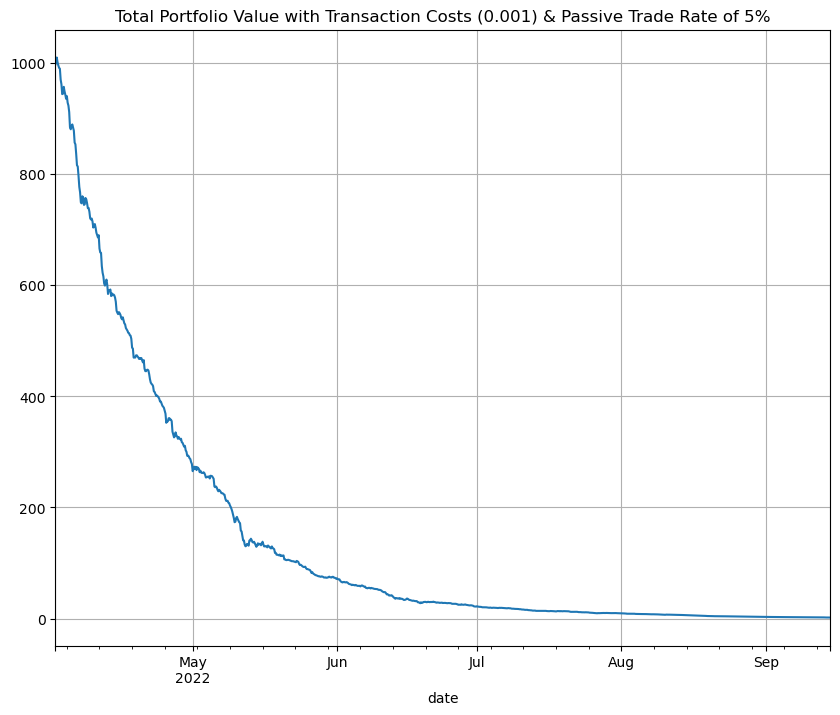

In [596]:
df_daily_portfolio_with_t_cost['total_portfolio_value'].plot(figsize=(10,8), grid=True, title='Total Portfolio Value with Transaction Costs (0.001) & Passive Trade Rate of 5%')

<Axes: title={'center': 'Available Cash with Transaction Costs (0.001) & Passive Trade Rate of 5%'}, xlabel='date'>

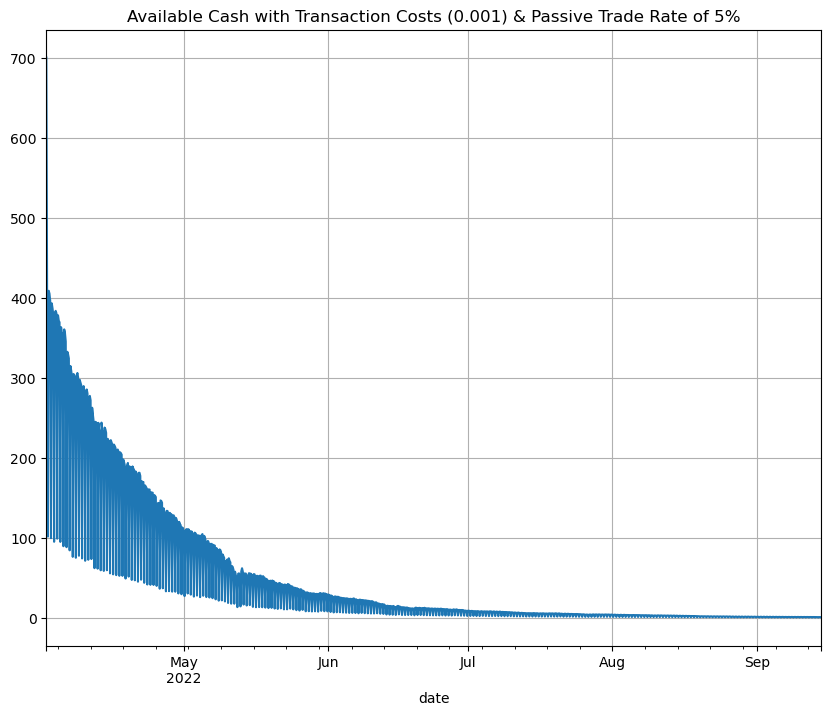

In [597]:
df_daily_portfolio_with_t_cost['available_cash'].plot(figsize=(10,8), grid=True, title='Available Cash with Transaction Costs (0.001) & Passive Trade Rate of 5%')

<Axes: title={'center': 'Turnover Plots'}, xlabel='date'>

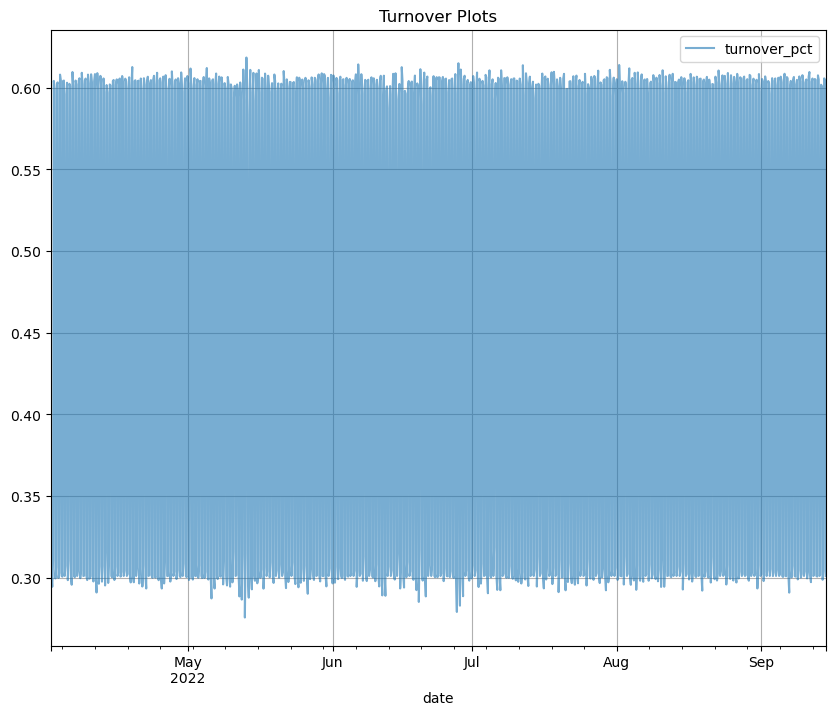

In [598]:
df_daily_portfolio_with_t_cost[['turnover_pct']].plot(
    figsize=(10,8), grid=True, title='Turnover Plots', alpha=0.6
)

<Axes: title={'center': 'Buy & Sell Turnover Plots'}, xlabel='date'>

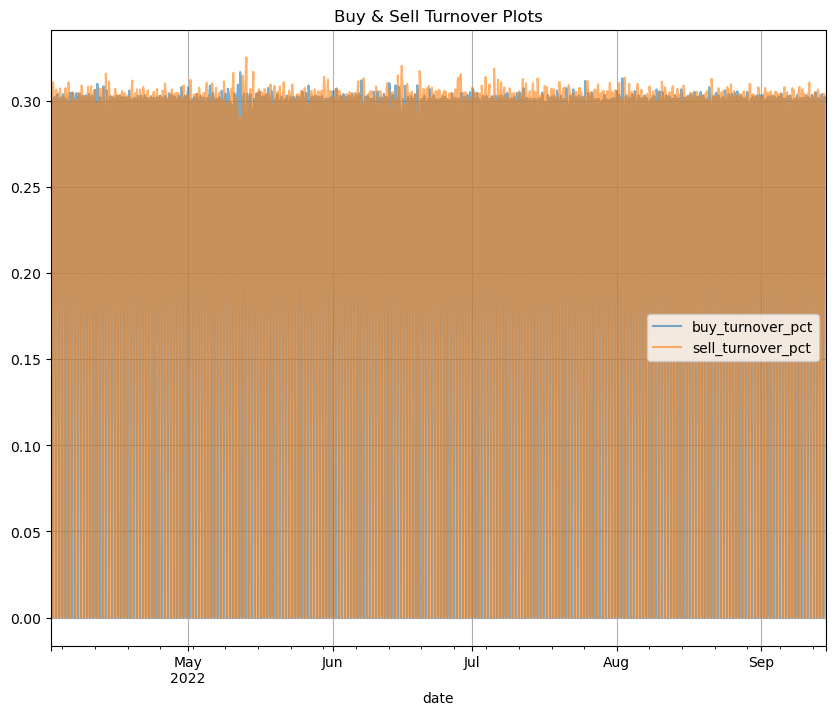

In [599]:
df_daily_portfolio_with_t_cost[['buy_turnover_pct','sell_turnover_pct']].plot(
    figsize=(10,8), grid=True, title='Buy & Sell Turnover Plots', alpha=0.6
)

<Axes: title={'center': 'Transaction Costs (0.001) & Passive Trade Rate of 5%'}, xlabel='date'>

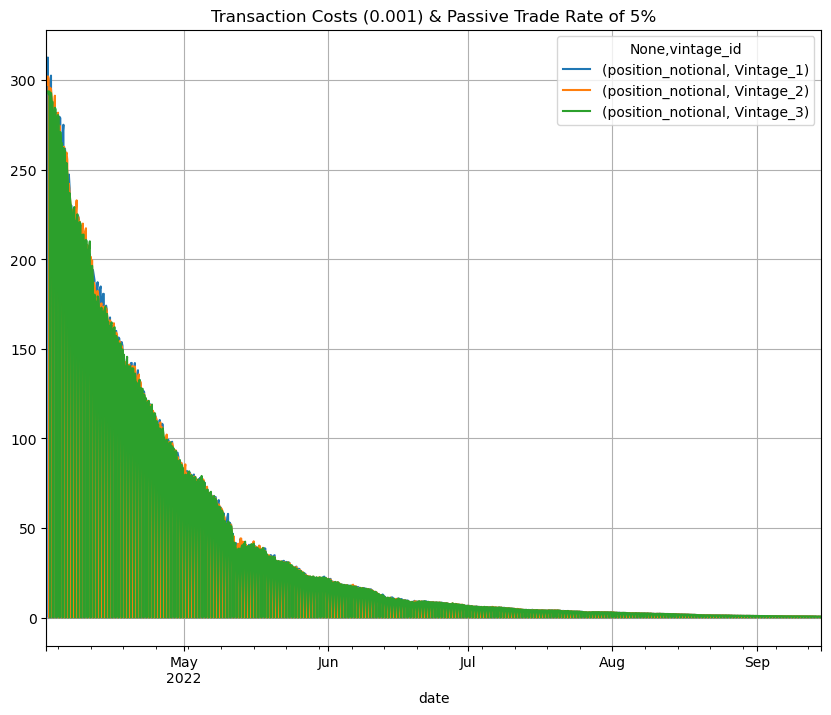

In [600]:
pd.pivot_table(df_daily_position_with_t_cost, index=['date'], columns=['vintage_id'], values=['position_notional'],
               aggfunc={'position_notional':'sum'}).plot(figsize=(10,8), grid=True, title='Transaction Costs (0.001) & Passive Trade Rate of 5%')

In [601]:
pd.pivot_table(df_daily_position_with_t_cost, index=['date'], columns=['vintage_id'], values=['position_notional'],
               aggfunc={'position_notional':'sum'}).head(50)

position_notional                        
vintage_id                  Vintage_1   Vintage_2   Vintage_3
date                                                         
2022-04-01 12:00:00        296.190000         NaN         NaN
2022-04-01 16:00:00        304.134330  297.414547         NaN
2022-04-01 20:00:00        312.614183  302.118475  293.633352
2022-04-02 00:00:00          0.000000  300.655957  292.116390
2022-04-02 04:00:00        296.564667    0.000000  293.646394
2022-04-02 08:00:00        299.522541  295.706857    0.000000
2022-04-02 12:00:00        302.518534  295.040462  292.793168
2022-04-02 16:00:00          0.000000  289.558365  287.557547
2022-04-02 20:00:00        287.283157    0.000000  287.852552
2022-04-03 00:00:00        282.326966  283.333159    0.000000
2022-04-03 04:00:00        284.488918  285.524135  279.764450
2022-04-03 08:00:00          0.000000  291.303041  284.587584
2022-04-03 12:00:00        281.744718    0.000000  283.653493
2022-04-03 16:00:00        281.514758  280.963631    0.000000
2022-04-03 20:00:00        279.588832  279.000693  278.119009
2022-04-04 00:00:00          0.000000  281.823024  280.543503
2022-04-04 04:00:00        278.491160    0.000000  278.863689
2022-04-04 08:00:00        279.500783  274.572804    0.000000
2022-04-04 12:00:00        278.765101  267.052965  271.009912
2022-04-04 16:00:00          0.000000  259.087167  262.080458
2022-04-04 20:00:00        261.875326    0.000000  264.910122
2022-04-05 00:00:00        269.774355  261.536000    0.000000
2022-04-05 04:00:00        275.084561  262.757420  262.166639
2022-04-05 08:00:00          0.000000  262.666546  260.763559
2022-04-05 12:00:00        261.744580    0.000000  260.701683
2022-04-05 16:00:00        253.889143  257.719562    0.000000
2022-04-05 20:00:00        252.061033  259.568707  253.756563
2022-04-06 00:00:00          0.000000  255.393229  248.447595
2022-04-06 04:00:00        245.485776    0.000000  241.266898
2022-04-06 08:00:00        247.322140  242.176617    0.000000
2022-04-06 12:00:00        239.523951  236.237475  236.903134
2022-04-06 16:00:00          0.000000  230.686681  231.672841
2022-04-06 20:00:00        230.102945    0.000000  227.975541
2022-04-07 00:00:00        222.899923  225.068848    0.000000
2022-04-07 04:00:00        224.546178  224.539563  222.173314
2022-04-07 08:00:00          0.000000  227.970251  227.486298
2022-04-07 12:00:00        225.085995    0.000000  229.151513
2022-04-07 16:00:00        222.501907  223.596381    0.000000
2022-04-07 20:00:00        224.009913  226.000700  220.684332
2022-04-08 00:00:00          0.000000  232.886115  221.844510
2022-04-08 04:00:00        223.561082    0.000000  225.112397
2022-04-08 08:00:00        224.091562  223.621776    0.000000
2022-04-08 12:00:00        221.881610  219.710798  219.585522
2022-04-08 16:00:00          0.000000  221.022724  220.770419
2022-04-08 20:00:00        218.881483    0.000000  219.825793
2022-04-09 00:00:00        214.592166  215.616685    0.000000
2022-04-09 04:00:00        213.364469  217.266349  213.519968
2022-04-09 08:00:00          0.000000  219.908203  213.727206
2022-04-09 12:00:00        211.544178    0.000000  213.737731
2022-04-09 16:00:00        209.407081  211.052450    0.000000

In [609]:
## No Transaction Costs and Passive Trade Rate of 100%
df_daily_position_wo_t_cost_p_rate_100, df_daily_portfolio_wo_t_cost_p_rate_100 = run_mean_reversion_backtest(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                              cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=0,
                                                                                                              passive_trade_rate=1, enable_fees=enable_fees)

0
100
200
300
400
500
600
700
800
900


<Axes: title={'center': 'Total Portfolio Value with No Transaction Costs & Passive Trade Rate of 100%'}, xlabel='date'>

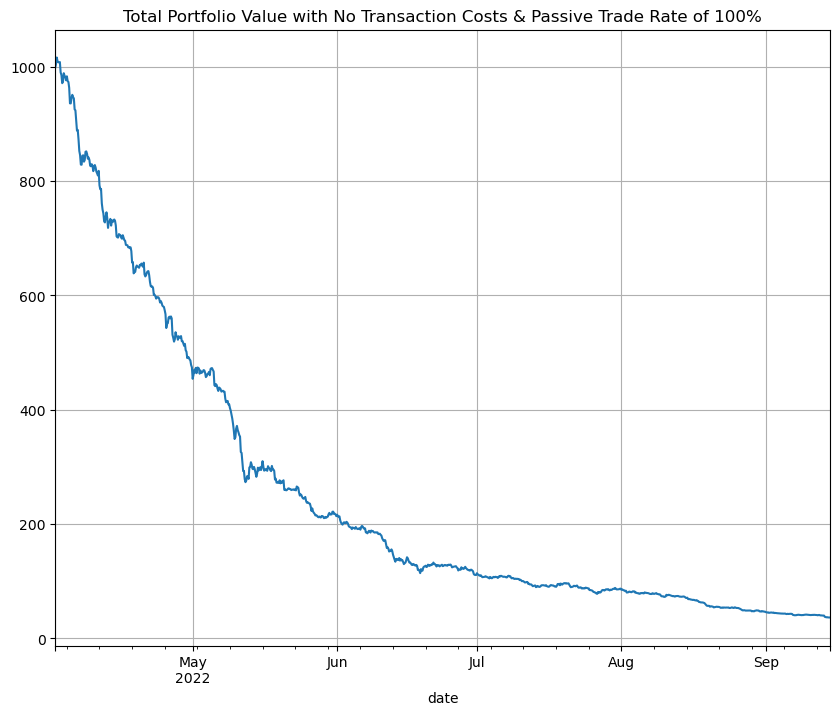

In [611]:
df_daily_portfolio_wo_t_cost_p_rate_100['total_portfolio_value'].plot(figsize=(10,8), grid=True, title='Total Portfolio Value with No Transaction Costs & Passive Trade Rate of 100%')

<Axes: title={'center': 'Available Cash Value with No Transaction Costs & Passive Trade Rate of 100%'}, xlabel='date'>

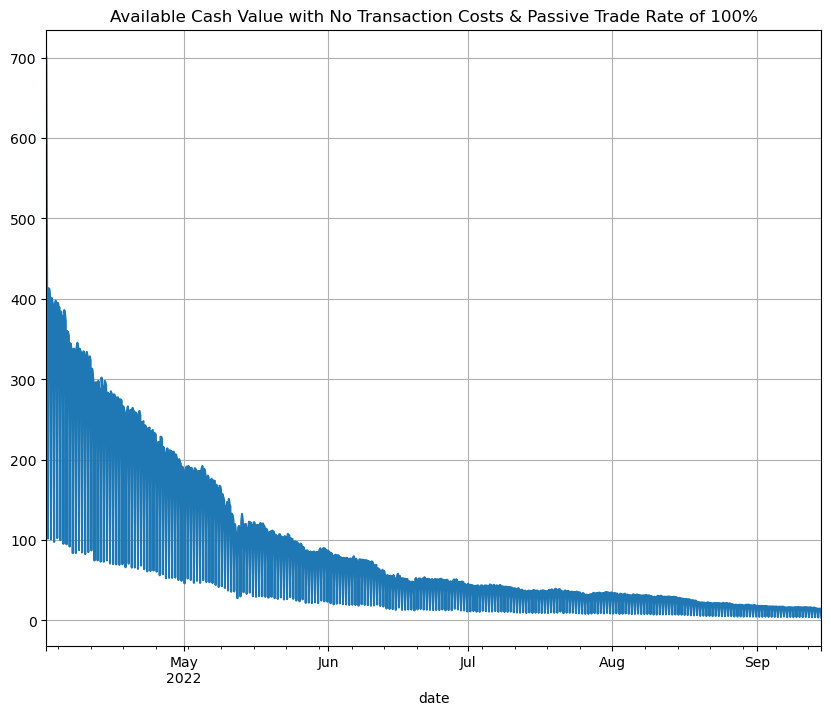

In [613]:
df_daily_portfolio_wo_t_cost_p_rate_100['available_cash'].plot(figsize=(10,8), grid=True, title='Available Cash Value with No Transaction Costs & Passive Trade Rate of 100%')

<Axes: title={'center': 'Turnover Plots'}, xlabel='date'>

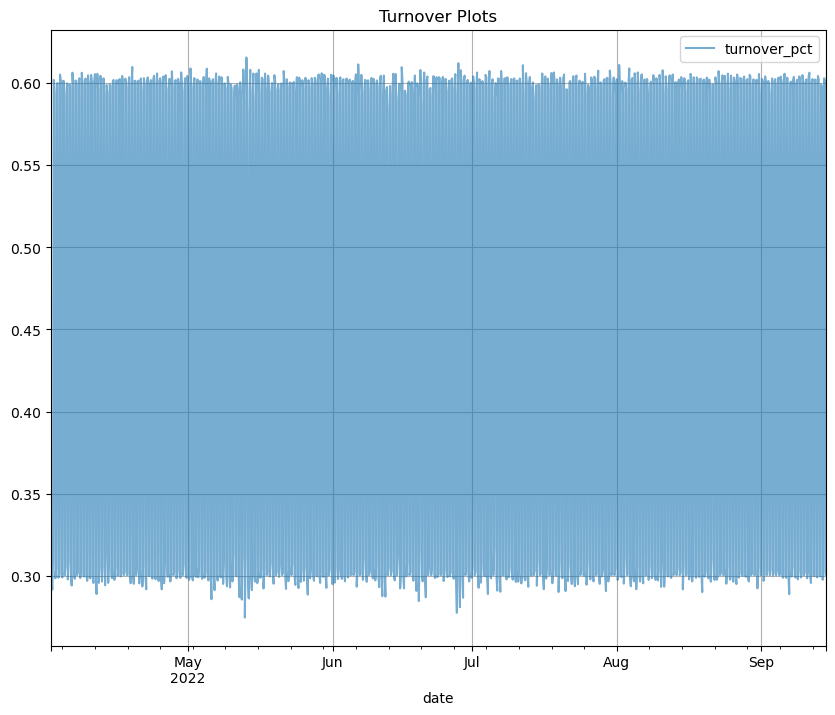

In [615]:
df_daily_portfolio_wo_t_cost_p_rate_100[['turnover_pct']].plot(
    figsize=(10,8), grid=True, title='Turnover Plots', alpha=0.6
)

<Axes: title={'center': 'Buy & Sell Turnover Plots'}, xlabel='date'>

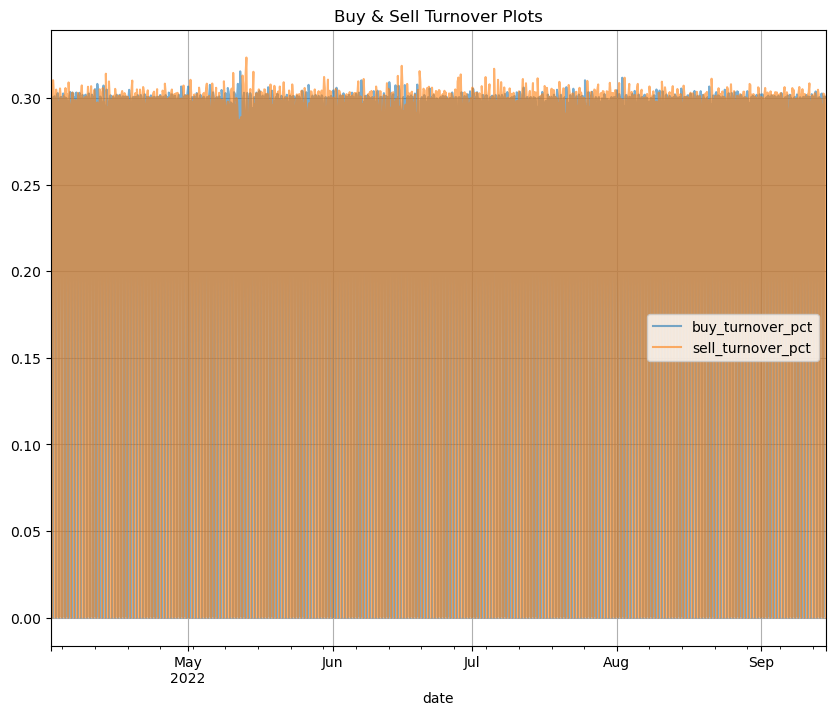

In [617]:
df_daily_portfolio_wo_t_cost_p_rate_100[['buy_turnover_pct','sell_turnover_pct']].plot(
    figsize=(10,8), grid=True, title='Buy & Sell Turnover Plots', alpha=0.6
)

<Axes: title={'center': 'No Transaction Costs and Passive Trade Rate of 100%'}, xlabel='date'>

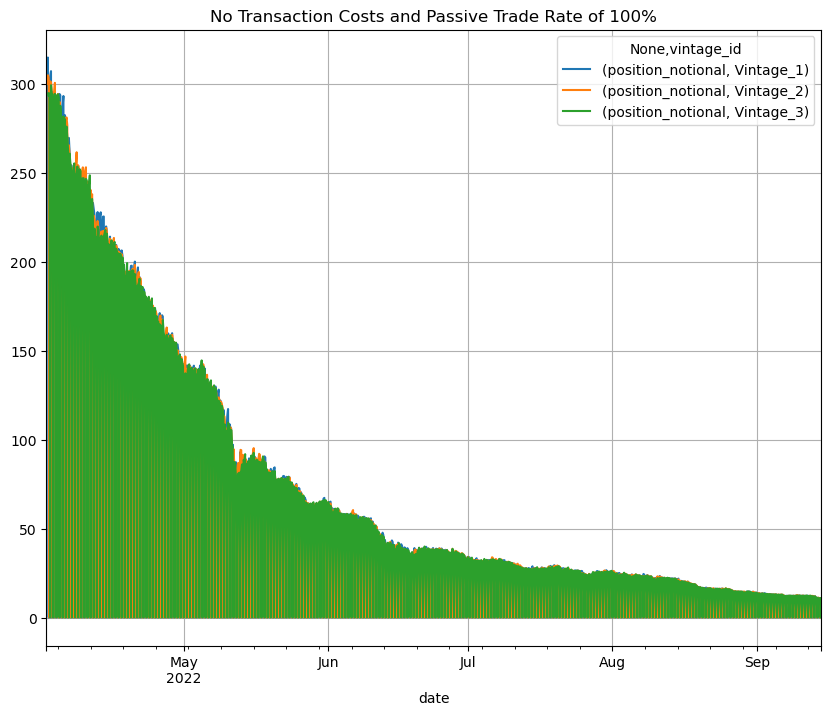

In [619]:
pd.pivot_table(df_daily_position_wo_t_cost_p_rate_100, index=['date'], columns=['vintage_id'], values=['position_notional'],
               aggfunc={'position_notional':'sum'}).plot(figsize=(10,8), grid=True, title='No Transaction Costs and Passive Trade Rate of 100%')

In [621]:
## No Transaction Costs or Exchange Fees
df_daily_position_wo_t_cost_or_exch_fees, df_daily_portfolio_wo_t_cost_or_exch_fees = run_mean_reversion_backtest(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                                  cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=0,
                                                                                                                  passive_trade_rate=1.0, enable_fees=False)

0
100
200
300
400
500
600
700
800
900


<Axes: title={'center': 'Total Portfolio Value with No Transaction Costs or Exchange Fees'}, xlabel='date'>

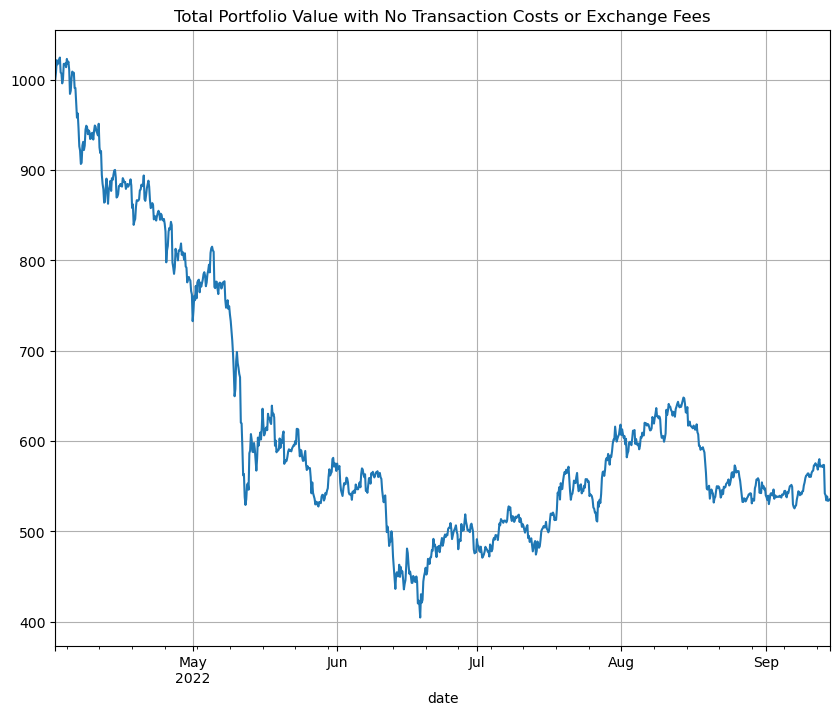

In [623]:
df_daily_portfolio_wo_t_cost_or_exch_fees['total_portfolio_value'].plot(figsize=(10,8), grid=True, title='Total Portfolio Value with No Transaction Costs or Exchange Fees')

<Axes: title={'center': 'Available Cash with No Transaction Costs or Exchange Fees'}, xlabel='date'>

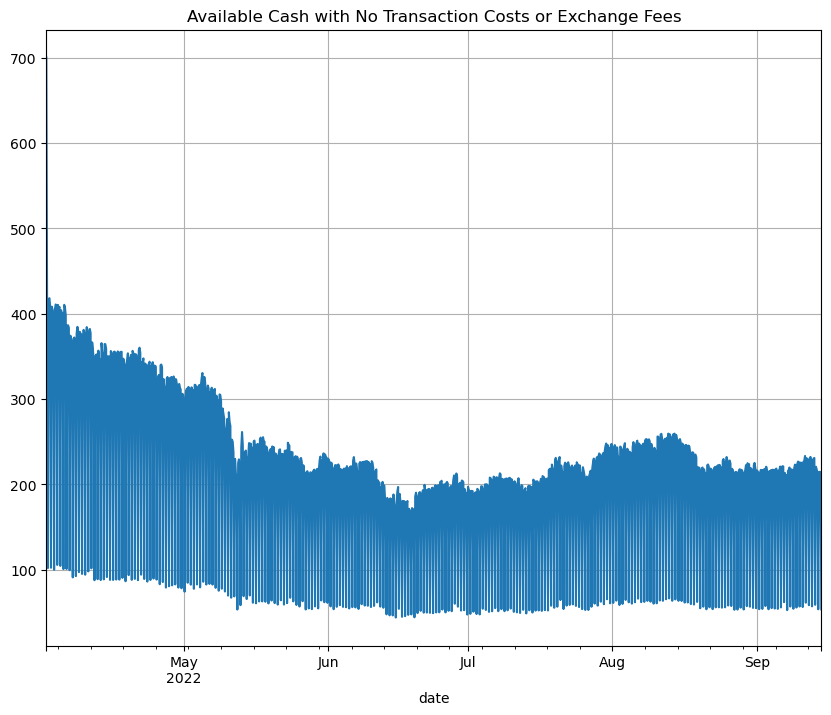

In [625]:
df_daily_portfolio_wo_t_cost_or_exch_fees['available_cash'].plot(figsize=(10,8), grid=True, title='Available Cash with No Transaction Costs or Exchange Fees')

<Axes: title={'center': 'Turnover Plots'}, xlabel='date'>

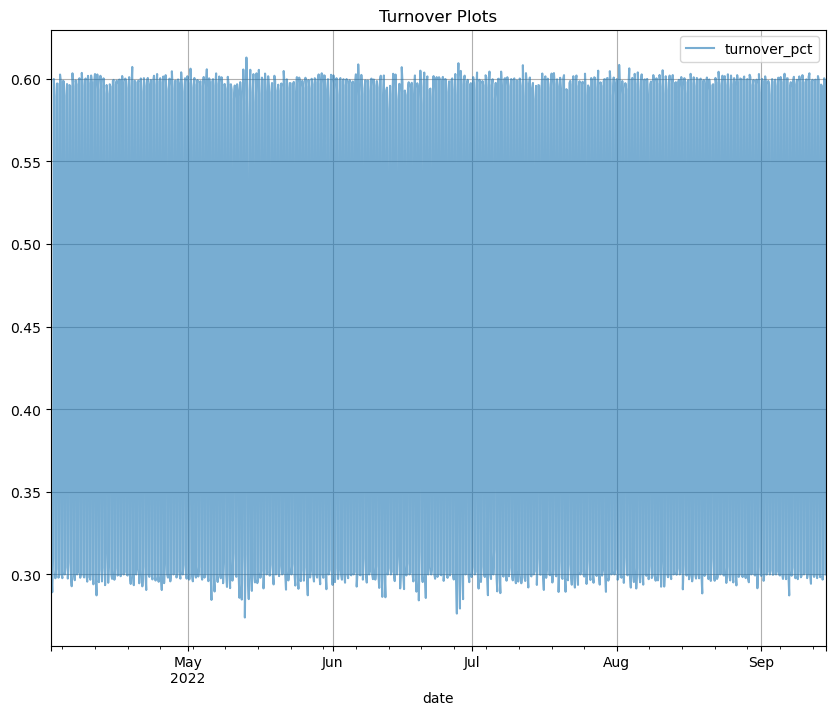

In [627]:
df_daily_portfolio_wo_t_cost_or_exch_fees[['turnover_pct']].plot(
    figsize=(10,8), grid=True, title='Turnover Plots', alpha=0.6
)

<Axes: title={'center': 'Buy & Sell Turnover Plots'}, xlabel='date'>

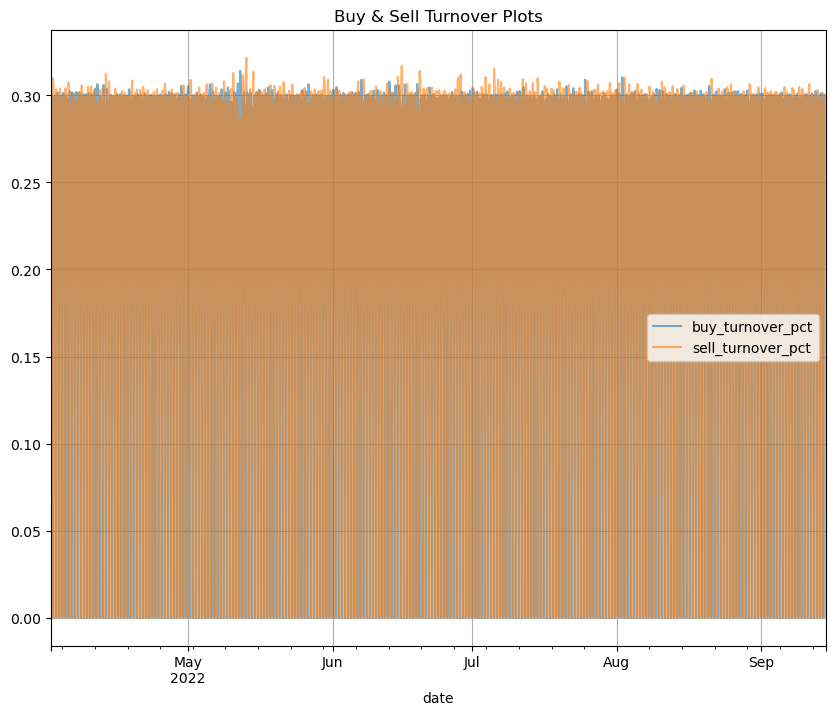

In [629]:
df_daily_portfolio_wo_t_cost_or_exch_fees[['buy_turnover_pct','sell_turnover_pct']].plot(
    figsize=(10,8), grid=True, title='Buy & Sell Turnover Plots', alpha=0.6
)

<Axes: title={'center': 'No Transaction Costs or Exchange Fees'}, xlabel='date'>

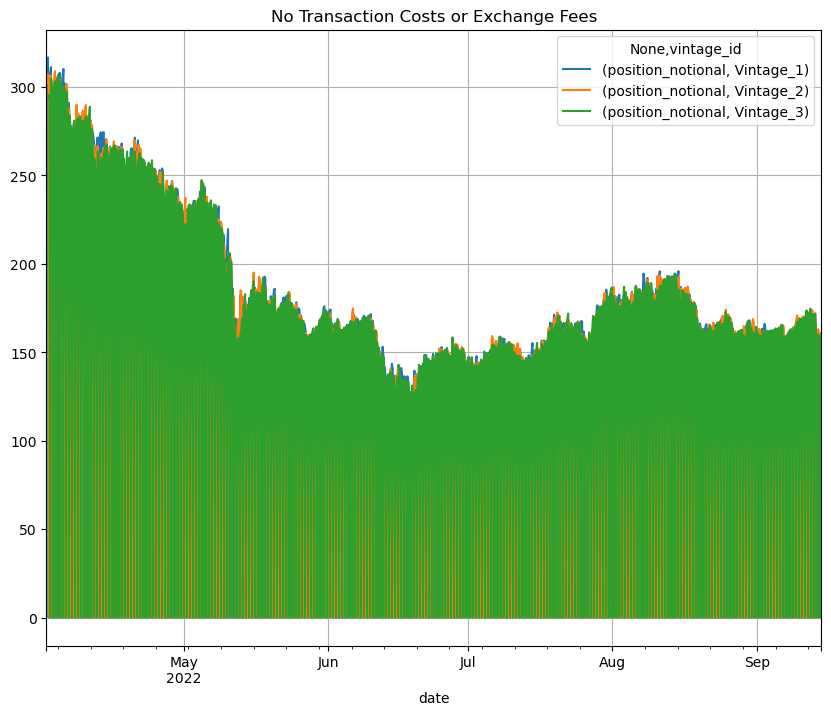

In [631]:
pd.pivot_table(df_daily_position_wo_t_cost_p_rate_5, index=['date'], columns=['vintage_id'], values=['position_notional'],
               aggfunc={'position_notional':'sum'}).plot(figsize=(10,8), grid=True, title='No Transaction Costs or Exchange Fees')

<Axes: title={'center': 'Portfolio Value'}, xlabel='date'>

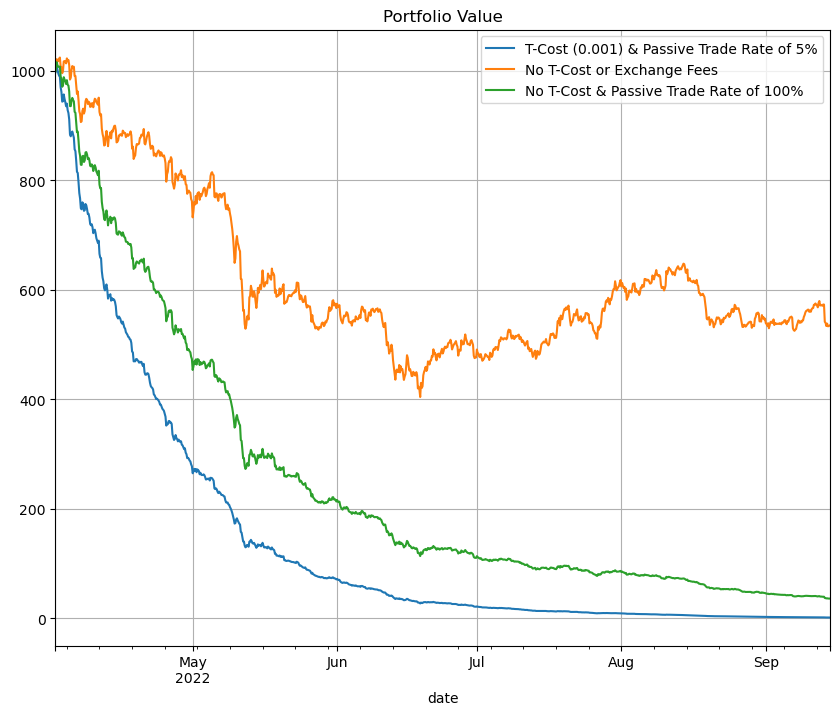

In [633]:
df_daily_portfolio_with_t_cost['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='T-Cost (0.001) & Passive Trade Rate of 5%', legend=True)
df_daily_portfolio_wo_t_cost_or_exch_fees['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='No T-Cost or Exchange Fees', legend=True)
df_daily_portfolio_wo_t_cost_p_rate_100['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='No T-Cost & Passive Trade Rate of 100%', title='Portfolio Value', legend=True)

<Axes: title={'center': 'Available Cash'}, xlabel='date'>

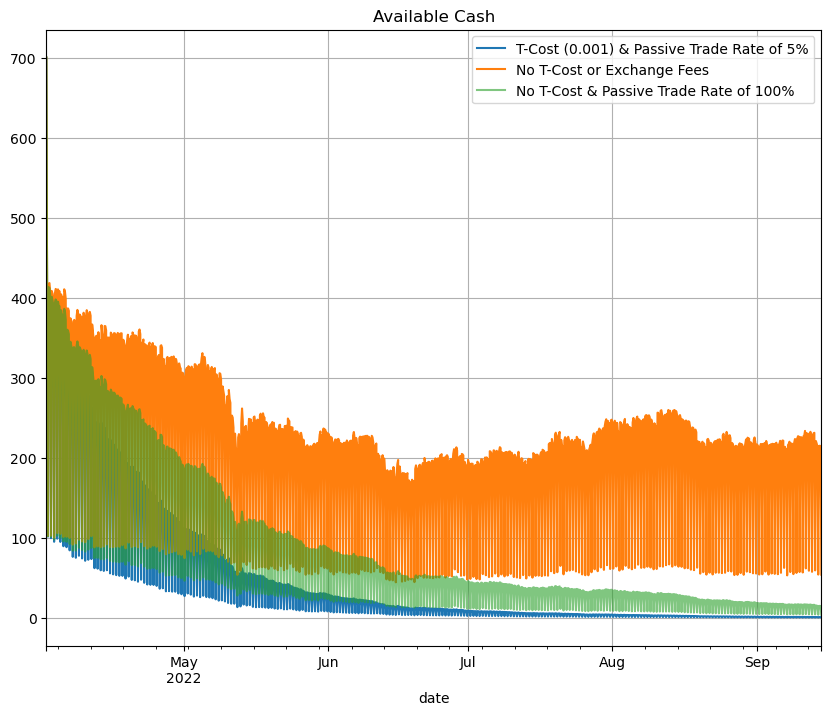

In [635]:
df_daily_portfolio_with_t_cost['available_cash'].plot(figsize=(10,8), grid=True, label='T-Cost (0.001) & Passive Trade Rate of 5%', legend=True)
df_daily_portfolio_wo_t_cost_or_exch_fees['available_cash'].plot(figsize=(10,8), grid=True, label='No T-Cost or Exchange Fees', legend=True)
df_daily_portfolio_wo_t_cost_p_rate_100['available_cash'].plot(figsize=(10,8), grid=True, label='No T-Cost & Passive Trade Rate of 100%', title='Available Cash', legend=True, alpha=0.6)

In [467]:
perf.estimate_fee_per_trade(passive_trade_rate=1.0)

0.006

In [ ]:
df_daily_position_with_t_cost.iloc[0]

In [ ]:
df_daily_position_wo_t_cost_p_rate_100.iloc[0]

In [ ]:
df_daily_position_wo_t_cost_p_rate_5.iloc[0]

In [ ]:
%%time

## Initialize the Cash and Portfolio Value prior to processing positions
available_cash = initial_capital
total_portfolio_value = initial_capital
total_portfolio_value_upper_limit = total_portfolio_value * (1 - cash_buffer_percentage)
first_period = pd.Timestamp('2022-04-01 08:00:00')
second_period = pd.Timestamp('2022-04-01 12:00:00')
third_period = pd.Timestamp('2022-04-01 16:00:00')

## Initialize Daily Portfolio Positions prior to processing positions
df_daily_portfolio_summary.loc[first_period, 'total_position_notional'] = 0.0
df_daily_portfolio_summary.loc[first_period, 'available_cash'] = initial_capital
df_daily_portfolio_summary.loc[first_period, 'total_portfolio_value'] = initial_capital
df_daily_portfolio_summary.loc[first_period, 'total_portfolio_value_upper_limit'] = initial_capital * (1 - cash_buffer_percentage)

run_counter = 0
run_counter_check = np.arange(0, len(period_list), 100).tolist()
for current_period in period_list[0:1000]:
    if run_counter in run_counter_check:
        print(run_counter)
    prior_period = period_list[period_list.index(current_period)-1]

    ## Filtering Conditions
    signal_current_period_cond = (df_signal.date == current_period)
    positions_current_period_cond = (df_daily_position_summary.date == current_period)
    positions_prior_period_cond = (df_daily_position_summary.date == prior_period)
    df_signal_current_period = df_signal.loc[signal_current_period_cond].copy()

    if current_period > first_period:
        df_daily_portfolio_summary = roll_portfolio_positions(df_daily_portfolio_summary, current_period=current_period)

    if current_period == first_period:
        ## Open New Positions for Vintage 1
        df_daily_position_summary, df_daily_portfolio_summary = open_new_vintage_positions(df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
                                                                                           period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                                                                                           transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, vintage_name='Vintage_1')
        non_zero_position_cond = (df_daily_position_summary['bottom_quintile_signal'])
        positions_vintage_cond = (df_daily_position_summary['vintage_id'] == 'Vintage_1')
        positions_current_period_cond = (df_daily_position_summary.date == current_period)
        df_daily_position_summary.loc[non_zero_position_cond & positions_current_period_cond & positions_vintage_cond, 'holding_period_counter'] = 1

    elif current_period == second_period:
        ## Update Positions from Vintage 1
        df_daily_position_summary, df_daily_portfolio_summary = update_open_vintage_positions(
            df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
            current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name='Vintage_1')

        ## Open New Positions for Vintage 2
        df_daily_position_summary, df_daily_portfolio_summary = open_new_vintage_positions(df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
                                                                                           period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                                                                                           transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, vintage_name='Vintage_2')
        non_zero_position_cond = (df_daily_position_summary['bottom_quintile_signal'])
        positions_vintage_cond = (df_daily_position_summary['vintage_id'] == 'Vintage_2')
        positions_current_period_cond = (df_daily_position_summary.date == current_period)
        df_daily_position_summary.loc[non_zero_position_cond & positions_current_period_cond & positions_vintage_cond, 'holding_period_counter'] = 1

    elif current_period == third_period:
        ## Update Positions from Vintage 1
        df_daily_position_summary, df_daily_portfolio_summary = update_open_vintage_positions(
            df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
            current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name='Vintage_1')

        ## Update Positions from Vintage 2
        df_daily_position_summary, df_daily_portfolio_summary = update_open_vintage_positions(
            df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
            current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name='Vintage_2')

        ## Open New Positions for Vintage 3
        df_daily_position_summary, df_daily_portfolio_summary = open_new_vintage_positions(df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
                                                                                           period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                                                                                           transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, vintage_name='Vintage_3')
        non_zero_position_cond = (df_daily_position_summary['bottom_quintile_signal'])
        positions_vintage_cond = (df_daily_position_summary['vintage_id'] == 'Vintage_3')
        positions_current_period_cond = (df_daily_position_summary.date == current_period)
        df_daily_position_summary.loc[non_zero_position_cond & positions_current_period_cond & positions_vintage_cond, 'holding_period_counter'] = 1

    else:
        vintage_list = df_daily_position_summary['vintage_id'].unique().tolist()
        for vintage in vintage_list:
            vintage_cond = (df_daily_position_summary['vintage_id'] == vintage)
            ## Check if holding period is equal to 3
            previous_period_holding_counter = df_daily_position_summary.loc[positions_prior_period_cond & vintage_cond, 'holding_period_counter'].values[0]
            
            if previous_period_holding_counter == 3:
                ## Exit all open positions in current period
                df_daily_position_summary, df_daily_portfolio_summary = exit_open_vintage_positions(
                    df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
                    current_period=current_period, prior_period=prior_period, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                    cash_buffer_percentage=cash_buffer_percentage, vintage_name=vintage)
                
            elif previous_period_holding_counter == 0:
                ## Open New Positions for Vintage
                df_daily_position_summary, df_daily_portfolio_summary = open_new_vintage_positions(df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
                                                                                                   period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                                                                                                   transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, vintage_name=vintage)
                non_zero_position_cond = (df_daily_position_summary['bottom_quintile_signal'])
                positions_vintage_cond = (df_daily_position_summary['vintage_id'] == vintage)
                positions_current_period_cond = (df_daily_position_summary.date == current_period)
                df_daily_position_summary.loc[non_zero_position_cond & positions_current_period_cond & positions_vintage_cond, 'holding_period_counter'] = 1
                
            elif (previous_period_holding_counter == 1) | (previous_period_holding_counter == 2):
                ## Update Positions from Vintage
                df_daily_position_summary, df_daily_portfolio_summary = update_open_vintage_positions(
                    df_position=df_daily_position_summary, df_portfolio=df_daily_portfolio_summary, df_signal=df_signal_current_period,
                    current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name=vintage)

    run_counter += 1

In [ ]:
df_daily_portfolio_summary.head(200)

In [ ]:
df_daily_portfolio_summary.tail(500)

In [ ]:
df_daily_position_summary.head(20)

In [ ]:
pd.pivot_table(df_daily_position_summary, index=['date'], columns=['vintage_id'], values=['position_notional'], aggfunc={'position_notional':'sum'}).plot(figsize=(12,10), grid=True)

In [ ]:
df_daily_position_summary.groupby(['date','vintage_id']).agg({'position_size':'sum', 'position_notional':'sum'}).head(20)

In [ ]:
df_daily_position_summary[(df_daily_position_summary['date'] == pd.Timestamp('2022-04-01 12:00:00')) & (df_daily_position_summary['vintage_id'] == 'Vintage_2')]

In [ ]:
date_cond = (df_signal.date == pd.Timestamp('2022-04-01 08:00:00'))
positions_weights = df_signal.loc[date_cond, 'weight']

date_cond = (df_signal.date == date)
weight_cond = (df_signal.weight != 0.0)
position_coins = df_signal.loc[date_cond & weight_cond]['ticker'].tolist()

In [ ]:
position_coins

In [ ]:
positions_weights * initial_capital

In [ ]:
df_signal[df_signal.date == pd.Timestamp('2022-04-01 08:00:00')]#.sort_values('z_ret_prev_4h')

In [ ]:
df_signal.head()